<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Predicting taxonomic identity and genetic composition based on codon usage bias levels
    </h1></td>
    <td width="35%">
    <div style="text-align: right">
    <b> Homework Machine Learning 2021 Course </b> <br>
    Bioinformatics for Computational Genomics <br>
    Mariachiara Grieco <br>
    Student ID: 10808343 <br>
    mariachiara.grieco@mail.polimi.it<br>
    </div>
    </td>
    <td width="100px"> 
        <a href="https://labolfattometrico.chem.polimi.it/wp-content/uploads/2019/12/POLIMI-corretto-3-1024x1024.jpg">
        <img align="right", width="100px" src="https://labolfattometrico.chem.polimi.it/wp-content/uploads/2019/12/POLIMI-corretto-3-1024x1024.jpg" alt=''>
        </a>
    </td>
</tr>
</table>

# Project

"The coding DNA of a genome describes the proteins of the organism in terms of 64 different codons that map to 21 different amino acids and a stop signal. Different organisms differ not only in the amino acid sequences of their proteins, but also in the extents in which they use the synonymous codons for different amino acids. The inherent redundancy of the genetic code allows the same amino acid to be specified by one to five different codons so that there are, in principle, many different nucleic acids to describe the primary structure of a given protein. Coding DNA sequences thus can carry information beyond that needed for encoding amino acid sequence. 
Thus, one may ask: **is it possible to classify some properties of nucleic acids from the usages of different synonymous codons rather than, with much greater computational effort, from individual nucleotide sequences themselves**?"
— Khomtchouk, Bohdan B. "Codon usage bias levels predict taxonomic identity and genetic com-
position." bioRxiv (2020).

This data set enables a preliminary analysis on this topic. 

**AIM**

Aim of this project is investigate the use of codon usage frequencies from several organisms to identify if they can be used to classify codon usage in terms of 11 Kingdoms: archea, bacteria, bacteriophage, plasmid, plant, invertebrate, vertebrate, mammal, rodent, primate and virus.


**DATA**

The data set consists of a total of 13.028 organisms (samples) classified both based on the organism species
(11 classes) and on the DNA type (11 classes). 
Features are all real valued and no data is missing, except for the AGA and ACA codon frequencies on test samples.

Each sample is described by 69 attributes:

- **Kingdom:** organism species
- **DNAtype:** type of DNA sample
- **SpeciesID:** an identifier of the species
- **Ncodons:** the total number of codons in the entry
- **SpeciesName:** the species of the organism
- **UUU - AUG:** the 64 codon frequencies (the codon occurrency count divided by the total number of codons Ncodons in the entry)

The dataset is provided already split into train (10422 samples) and test (2606 samples) sets. While the
training set comes with all the 64 codon frequencies for each sample, a malfunctioning in the analysis
procedure caused the measurements of the AGA and ACA codon frequencies to be lost in all test samples.
- train.csv : 10422 × 69 dataset
- test.csv : 2606 × 67 dataset

In [630]:
# for data manipulation
import pandas as pd
import numpy as np
from numpy import cumsum
from collections import OrderedDict

# for data visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

#from ipynb.fs.full.collection_functions import *

# for machine learning analysis
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, plot_confusion_matrix, accuracy_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import time
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

We start loading the training dataset and we take a look to the data.
We can see that there aren't missing values and all columns.

In [609]:
# Read the data and create a pandas DataFrame
train = pd.read_csv("ML2021-homework-new/train.csv")
train=train.drop('Unnamed: 0', axis=1)
train

Kingdom  DNAtype  SpeciesID  Ncodons  \
0         vrl        0     207343     6686   
1         inv        0       7629    10060   
2         bct        0     320850    14031   
3         bct        0       1397    39839   
4         vrt        1      50790     5112   
...       ...      ...        ...      ...   
10417     pln        0     332388     1791   
10418     vrl        0     374598    68352   
10419     bct        0     267998     2292   
10420     pln        2     175050     1022   
10421     pln        2      36012     1026   

                                SpeciesName      UUU      UUC      UUA  \
0                        Bovine foamy virus  0.01541  0.00927  0.01720   
1                  Anthocidaris crassispina  0.01213  0.02515  0.00268   
2                   Staphylococcus phage X2  0.02580  0.01618  0.03606   
3                        Bacillus circulans  0.00128  0.02141  0.01225   
4      mitochondrion Dascyllus trimaculatus  0.03169  0.01780  0.03893   
...                                     ...      ...      ...      ...   
10417            Pyrus pyrifolia var. culta  0.02289  0.02959  0.00614   
10418     Eastern equine encephalitis virus  0.02532  0.01557  0.00878   
10419               Rhizobium sp. MTP-10005  0.01614  0.02618  0.00131   
10420        chloroplast Primula chungensis  0.00196  0.01761  0.04501   
10421               chloroplast Nageia nagi  0.01754  0.03704  0.01559   

           UUG      CUU  ...      CGG      AGA      AGG      GAU      GAC  \
0      0.01825  0.01436  ...  0.00643  0.02064  0.01182  0.02812  0.00838   
1      0.01352  0.01372  ...  0.00268  0.00915  0.01412  0.03280  0.02555   
2      0.01354  0.00848  ...  0.00114  0.01775  0.00499  0.03756  0.02523   
3      0.01649  0.01330  ...  0.01177  0.00705  0.00422  0.03316  0.02229   
4      0.00000  0.06240  ...  0.00000  0.00000  0.00000  0.00020  0.01389   
...        ...      ...  ...      ...      ...      ...      ...      ...   
10417  0.02680  0.01452  ...  0.00558  0.00893  0.01173  0.03071  0.01954   
10418  0.01185  0.01160  ...  0.00477  0.01274  0.01008  0.02070  0.00726   
10419  0.01003  0.02661  ...  0.01702  0.00175  0.00567  0.02487  0.00000   
10420  0.03131  0.02544  ...  0.00391  0.01566  0.00391  0.02348  0.01957   
10421  0.01852  0.01949  ...  0.00390  0.01754  0.00975  0.03314  0.00390   

           GAA      GAG      UAA      UAG      UGA  
0      0.03365  0.01974  0.01511  0.00030  0.00030  
1      0.03708  0.05398  0.03330  0.00030  0.00050  
2      0.05388  0.01946  0.02245  0.00121  0.00086  
3      0.03444  0.02370  0.00831  0.00028  0.00063  
4      0.02465  0.00352  0.00352  0.00000  0.02465  
...        ...      ...      ...      ...      ...  
10417  0.01787  0.02848  0.03127  0.00112  0.00000  
10418  0.02388  0.02233  0.01814  0.00025  0.00038  
10419  0.02661  0.02618  0.01353  0.00000  0.00349  
10420  0.03523  0.00978  0.00196  0.00000  0.00196  
10421  0.03899  0.00780  0.00195  0.00000  0.00195  

[10422 rows x 69 columns]

In [4]:
# Investigate the presence of missing value
np.any(trateain.isna(), axis=1).sum()

0

We sort and store the name of the kingdoms and of the different DNA types.
At a first sight, we already can see two classes are missed in the dataset for what regards the DNA types.
In particular, zero samples are present for 'leucoplast' and 'proplastid' types.

In [5]:
kgd=np.sort(train['Kingdom'].unique())
dt=np.sort(train['DNAtype'].unique())
print(kgd)
print(dt)

kingdom_name=["archaea","bacteria","invertebrate","mammal","bacteriophage","plasmid",
              "plant","primate","rodent","virus","vertebrate"]

dnatype_name=["genomic","mitochondrial","chloroplast","cyanelle","plastid","nucleomorph",
              "secondary_endosymbiont","chromolast","NA","apicoplas","kinetoplast"]

['arc' 'bct' 'inv' 'mam' 'phg' 'plm' 'pln' 'pri' 'rod' 'vrl' 'vrt']
[ 0  1  2  3  4  5  6  7  9 11 12]


We create two ordered dictionaries, containing the label and the full name of each kingdom and DNA type, that will be used after.

In [6]:
dict_kingdom=OrderedDict()
for name,k in zip(kingdom_name,kgd):
    dict_kingdom.update([(name,k)])

dict_dnatype=OrderedDict()
for name,d in zip(dnatype_name,dt):
    dict_dnatype.update([(name,d)])

Now, let's start to get an idea of our dataset by plotting the data.
We will use mainly the seaborn package 

Firstly, we can have look to the number of samples belonging to each kingdom.
The results are shown in the table and plotted in the barplot below.
We can see that our classes (kingdoms) are not balanced: for example, the plasmid one contains only few samples (14), while the bacteria kingdom is the biggest.

In [8]:
kgd_counts=pd.DataFrame()
for name,sign in dict_kingdom.items():
    tot_train=train[train.Kingdom == sign].shape[0]    
    count=pd.DataFrame()
    count['kingdom']=[sign]
    count['name']=[name]
    count['tot_train']=[tot_train]

    kgd_counts=pd.concat([kgd_counts,count],axis=0)
    
kgd_counts=kgd_counts.set_index('kingdom')
kgd_counts

name  tot_train
kingdom                          
arc            archaea        101
bct           bacteria       2336
inv       invertebrate       1076
mam             mammal        458
phg      bacteriophage        176
plm            plasmid         14
pln              plant       2018
pri            primate        144
rod             rodent        172
vrl              virus       2265
vrt         vertebrate       1662

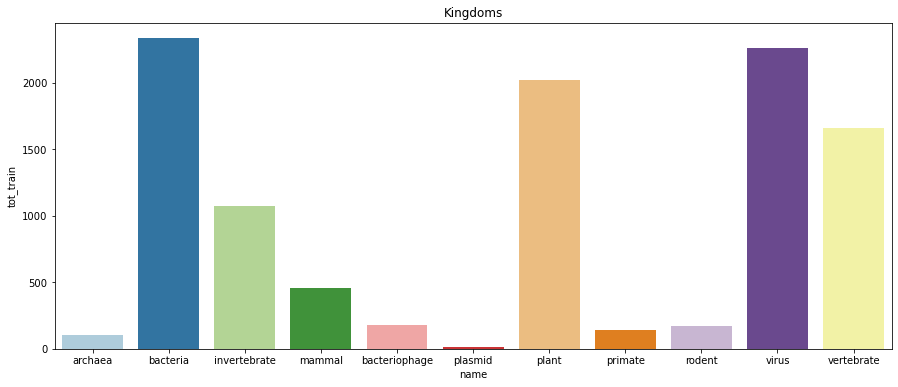

In [9]:
_=plt.figure(figsize = (15,6))
_ = sns.barplot(x = 'name', y = "tot_train", data = kgd_counts, palette="Paired")
_=plt.title('Kingdoms')

We can also look at the number of samples belonging to each DNA type class.
As before, the results are shown in the table and plotted in the barplot below.
We can see that only the genomic (7407), mithocondrial (2320) and chloroplast (658) classes contain a consistent number of samples.

In [11]:
dt_counts=pd.DataFrame()
for name,sign in dict_dnatype.items():
    tot_train=train[train.DNAtype == sign].shape[0]

    count=pd.DataFrame()
    count['dnatype']=[sign]
    count['name']=[name]
    count['tot_train']=[tot_train]
    
    dt_counts=pd.concat([dt_counts,count],axis=0)
    
dt_counts=dt_counts.set_index('dnatype')
dt_counts


name  tot_train
dnatype                                   
0                       genomic       7407
1                 mitochondrial       2320
2                   chloroplast        658
3                      cyanelle          2
4                       plastid         24
5                   nucleomorph          1
6        secondary_endosymbiont          1
7                    chromolast          1
9                            NA          2
11                    apicoplas          1
12                  kinetoplast          5

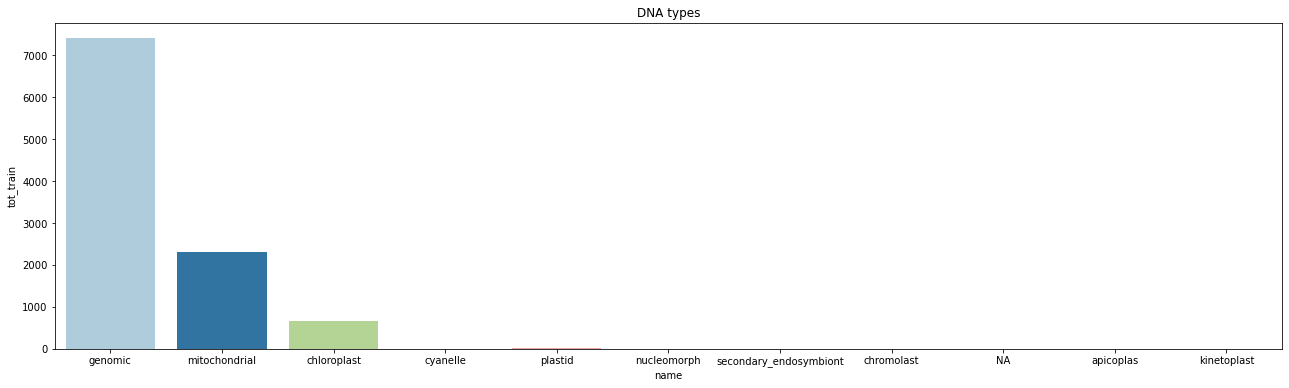

In [12]:
_=plt.figure(figsize = (22,6))
_ = sns.barplot(x = 'name', y = "tot_train", data = dt_counts, palette="Paired")
_=plt.title('DNA types')

In the dataset, there is also a column referred to the specie of the samples.
It will not use in the downstream analysis, but just for curiosity, we can investigate how many different species are contained.
We can say that the species are almost all different: in fact, doing a unique() on the species s name, we get 9995 unique species names out of 10422 total samples.

In [13]:
print("number of species included",len(train["SpeciesID"]))
print("number of unique species included",len(train["SpeciesID"].unique()))
print(train["SpeciesID"].unique())

number of species included 10422
number of unique species included 9995
[207343   7629 320850 ... 267998 175050  36012]


For what regards the codons, that are the features we will use for the downstream analysis, we can check the distribution of the number of codons among the kingdoms.
The mean of codons for each kingdom is reported in the table, while the distribution of number of codons over the samples belonging to the same kingdom is represented in the violin plot below.
From a prettly visual point of view, we can see that the archea class has the most spread distribution, furthermore that the kingdoms belonging to the eukariotyc domain (inv,mam,pln,inv,vrt,mam,rod,pri) have a shape quite common. 
(Note: as clarification, the total number of codons is intended as the total number of codons in the whole genome of each sample for this reason the number is high and not equal to 64 (number of codons in the genetic code).

Ncodons
Kingdom          
arc      211120.0
bct      196483.0
inv       58500.0
mam       23649.0
phg        9798.0
plm       13769.0
pln       50133.0
pri       90189.0
rod      194369.0
vrl       23033.0
vrt       14889.0

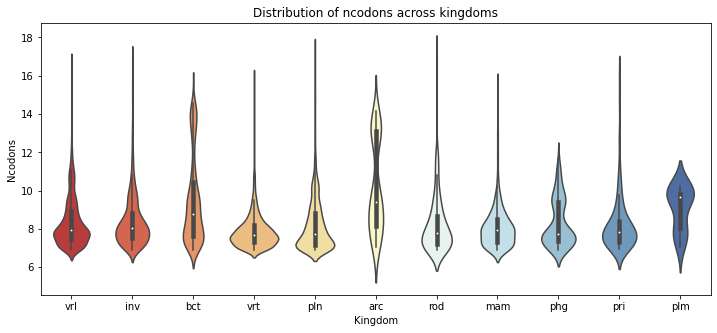

In [14]:
###distribution of codons among kingdom
ncod= train[["Kingdom","Ncodons"]].copy()
ncod_count=round(ncod.groupby("Kingdom").mean())
ncod_count

_=plt.figure(figsize=(12,5))
_=sns.violinplot(data=ncod,x="Kingdom",y=np.log(ncod.loc[:,"Ncodons"]), palette='RdYlBu')
_=plt.title('Distribution of ncodons across kingdoms')
#in the plot i take the log of ncod to better visualize it

Moreover, we can plot the distribution of the frequencies of each codon over all samples using a violiplot again.
We can see that some codons have a wide range of values, while others are on a smaller scale.

In [ ]:
#violin plot with all codon frequencies
_=plt.figure(figsize=(5,20))
_= sns.set_style("whitegrid")
_=sns.violinplot(data=codfreq,scale="count",orient="h", palette='RdYlBu')
_=_.set(xlabel='Codon', ylabel='Frequency', title="Codon frequencies")
# _.xaxis.set_ticks_position('bottom')


### LABEL ENCODING

In order to use machine learning algorithm we have to encode the kingdom labels (categorical data) in numerical data, that can be done using different tecniques, in particular we will use the label encoding and the one-hot encoding.

Label Encoding is a popular encoding technique for handling categorical variables, assigning to each label a unique integer from 0 to n, where n is the total number of classes in the dataset, in our case 11 as the total number of kingdoms.

This is carried out using the LabelEncoder() function in sklearn.

From assigning a progressive number to the class could arise some problems, for example we might confuse our model into thinking that a column has data with some kind of order or hierarchy when we clearly don’t have it

To overcome this problem and perform a correlation analysis, we ‘OneHotEncode’ the Kingdom column and so investigate the correlations (if present) between features and the 11 kingdoms.
What one hot encoding does is, it takes a column of categorical data (which has already been label encoded eventually) and then splits the column into multiple columns. The numbers are replaced by 1s and 0s, depending on which column has what value.

In [645]:
##CLASS LABELS CATEGORICAL VALUES: LABEL ENCODING
##https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/
##https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b

# firstly i perform a label encoding , then for the correlation i perform the one-hot to overcome the issue of the 
# undesidered implicit order among the labels 0-9

# label encoding kgd
label_kgd = train['Kingdom'] 
le = preprocessing.LabelEncoder()
coded_label_kgd = le.fit_transform(label_kgd)
train['Kingdom_coded']  = le.fit_transform(train['Kingdom'])
train

#one hot encoding for kgd and dnatype
dummies_kgd = pd.get_dummies(train['Kingdom'])
dummies_dt = pd.get_dummies(train['DNAtype'], prefix = 'dnatype') 
train_corr = pd.concat([train, dummies_kgd, dummies_dt], axis = 1)

train_corr.drop(['Kingdom', 'DNAtype','SpeciesID','SpeciesName','Kingdom_coded'], axis = 1, inplace = True)
train_corr

Kingdom  DNAtype  SpeciesID  Ncodons  \
0         vrl        0     207343     6686   
1         inv        0       7629    10060   
2         bct        0     320850    14031   
3         bct        0       1397    39839   
4         vrt        1      50790     5112   
...       ...      ...        ...      ...   
10417     pln        0     332388     1791   
10418     vrl        0     374598    68352   
10419     bct        0     267998     2292   
10420     pln        2     175050     1022   
10421     pln        2      36012     1026   

                                SpeciesName      UUU      UUC      UUA  \
0                        Bovine foamy virus  0.01541  0.00927  0.01720   
1                  Anthocidaris crassispina  0.01213  0.02515  0.00268   
2                   Staphylococcus phage X2  0.02580  0.01618  0.03606   
3                        Bacillus circulans  0.00128  0.02141  0.01225   
4      mitochondrion Dascyllus trimaculatus  0.03169  0.01780  0.03893   
...                                     ...      ...      ...      ...   
10417            Pyrus pyrifolia var. culta  0.02289  0.02959  0.00614   
10418     Eastern equine encephalitis virus  0.02532  0.01557  0.00878   
10419               Rhizobium sp. MTP-10005  0.01614  0.02618  0.00131   
10420        chloroplast Primula chungensis  0.00196  0.01761  0.04501   
10421               chloroplast Nageia nagi  0.01754  0.03704  0.01559   

           UUG      CUU  ...      AGA      AGG      GAU      GAC      GAA  \
0      0.01825  0.01436  ...  0.02064  0.01182  0.02812  0.00838  0.03365   
1      0.01352  0.01372  ...  0.00915  0.01412  0.03280  0.02555  0.03708   
2      0.01354  0.00848  ...  0.01775  0.00499  0.03756  0.02523  0.05388   
3      0.01649  0.01330  ...  0.00705  0.00422  0.03316  0.02229  0.03444   
4      0.00000  0.06240  ...  0.00000  0.00000  0.00020  0.01389  0.02465   
...        ...      ...  ...      ...      ...      ...      ...      ...   
10417  0.02680  0.01452  ...  0.00893  0.01173  0.03071  0.01954  0.01787   
10418  0.01185  0.01160  ...  0.01274  0.01008  0.02070  0.00726  0.02388   
10419  0.01003  0.02661  ...  0.00175  0.00567  0.02487  0.00000  0.02661   
10420  0.03131  0.02544  ...  0.01566  0.00391  0.02348  0.01957  0.03523   
10421  0.01852  0.01949  ...  0.01754  0.00975  0.03314  0.00390  0.03899   

           GAG      UAA      UAG      UGA  Kingdom_coded  
0      0.01974  0.01511  0.00030  0.00030              9  
1      0.05398  0.03330  0.00030  0.00050              2  
2      0.01946  0.02245  0.00121  0.00086              1  
3      0.02370  0.00831  0.00028  0.00063              1  
4      0.00352  0.00352  0.00000  0.02465             10  
...        ...      ...      ...      ...            ...  
10417  0.02848  0.03127  0.00112  0.00000              6  
10418  0.02233  0.01814  0.00025  0.00038              9  
10419  0.02618  0.01353  0.00000  0.00349              1  
10420  0.00978  0.00196  0.00000  0.00196              6  
10421  0.00780  0.00195  0.00000  0.00195              6  

[10422 rows x 70 columns]

Ncodons      UUU      UUC      UUA      UUG      CUU      CUC      CUA  \
0         6686  0.01541  0.00927  0.01720  0.01825  0.01436  0.02303  0.01555   
1        10060  0.01213  0.02515  0.00268  0.01352  0.01372  0.01143  0.00775   
2        14031  0.02580  0.01618  0.03606  0.01354  0.00848  0.02067  0.01041   
3        39839  0.00128  0.02141  0.01225  0.01649  0.01330  0.01308  0.00399   
4         5112  0.03169  0.01780  0.03893  0.00000  0.06240  0.01056  0.05262   
...        ...      ...      ...      ...      ...      ...      ...      ...   
10417     1791  0.02289  0.02959  0.00614  0.02680  0.01452  0.02178  0.00558   
10418    68352  0.02532  0.01557  0.00878  0.01185  0.01160  0.02654  0.00979   
10419     2292  0.01614  0.02618  0.00131  0.01003  0.02661  0.01658  0.00218   
10420     1022  0.00196  0.01761  0.04501  0.03131  0.02544  0.00978  0.01761   
10421     1026  0.01754  0.03704  0.01559  0.01852  0.01949  0.05263  0.02534   

           CUG      AUU  ...  dnatype_1  dnatype_2  dnatype_3  dnatype_4  \
0      0.02094  0.01885  ...          0          0          0          0   
1      0.02992  0.01352  ...          0          0          0          0   
2      0.00278  0.03250  ...          0          0          0          0   
3      0.02834  0.02508  ...          0          0          0          0   
4      0.01408  0.03873  ...          1          0          0          0   
...        ...      ...  ...        ...        ...        ...        ...   
10417  0.01228  0.02401  ...          0          0          0          0   
10418  0.02313  0.01773  ...          0          0          0          0   
10419  0.04712  0.01920  ...          0          0          0          0   
10420  0.00783  0.04305  ...          0          1          0          0   
10421  0.00975  0.04483  ...          0          1          0          0   

       dnatype_5  dnatype_6  dnatype_7  dnatype_9  dnatype_11  dnatype_12  
0              0          0          0          0           0           0  
1              0          0          0          0           0           0  
2              0          0          0          0           0           0  
3              0          0          0          0           0           0  
4              0          0          0          0           0           0  
...          ...        ...        ...        ...         ...         ...  
10417          0          0          0          0           0           0  
10418          0          0          0          0           0           0  
10419          0          0          0          0           0           0  
10420          0          0          0          0           0           0  
10421          0          0          0          0           0           0  

[10422 rows x 87 columns]

Sometimes we can visualize the features by a pairplot, but in this case the number of features is too high and so we have to use a heatmap showing the correlation matrix.

We can see that the number of codons does not correlate with any features.
For what regard the type of DNA, there are some correlations between the three major included DNA types and some codons. In particular, we see that some codons could discriminate between the genomic and mithocondrial genome.
Focusing on the kingdoms, we can notice that only few codons are slightly higher expressed in a kingdom than the other ones, such as 'GGC' and 'CCA' in the archea.
Looking this heatmap, we can conclude also that not a single codon frequency can distinguish a kingdom form another.

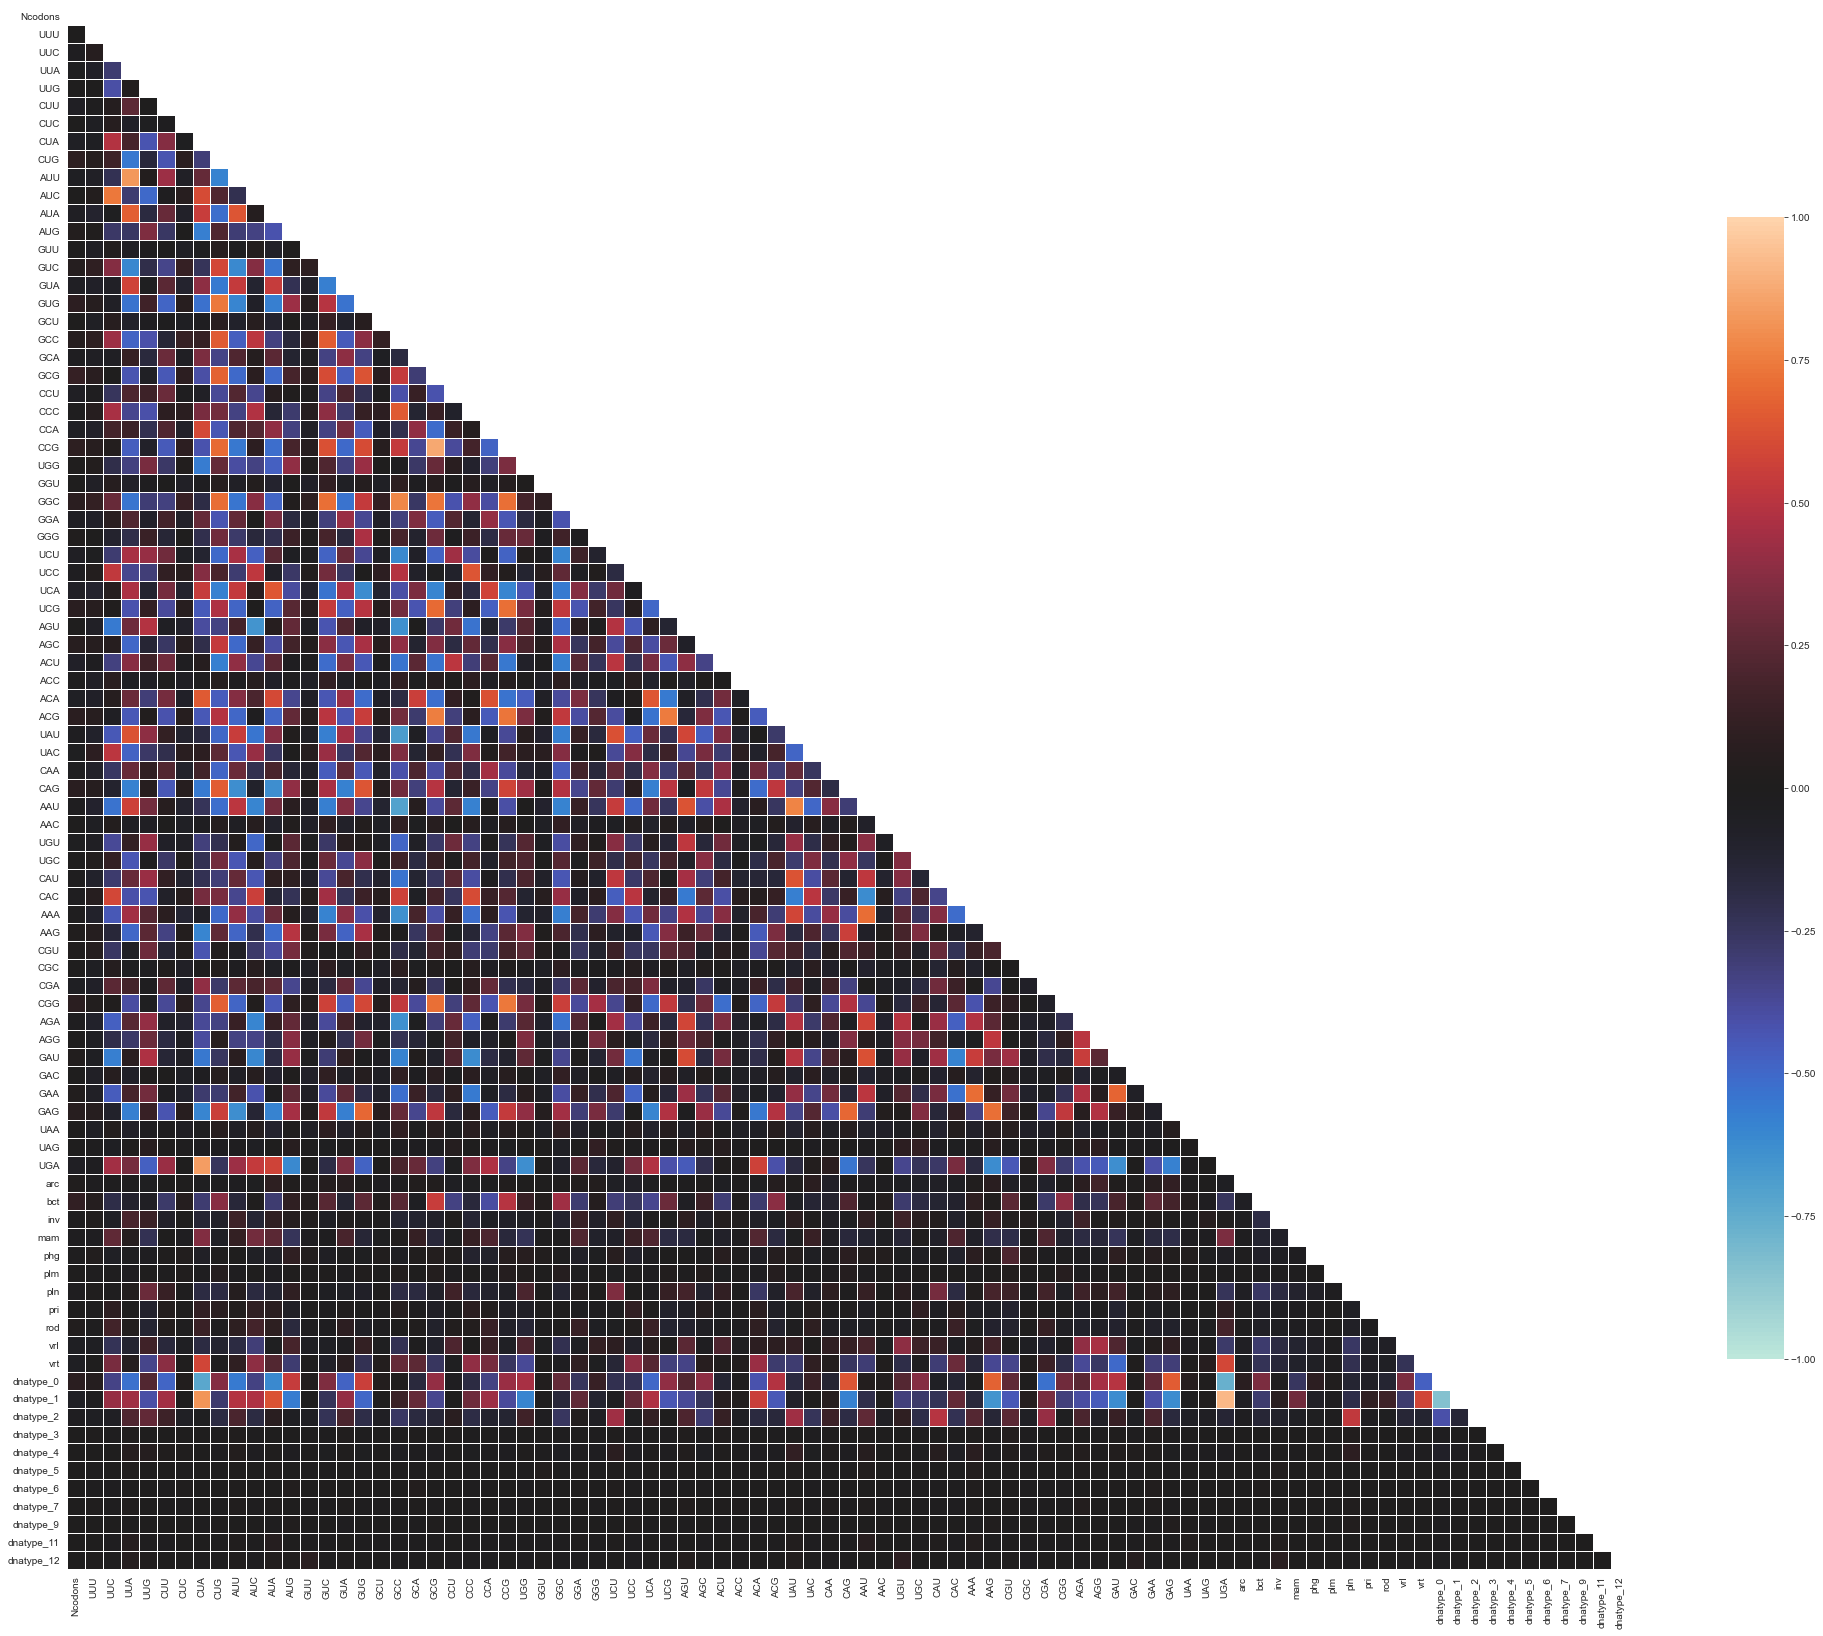

In [601]:
##correlation matrix
corrmatrix = train_corr.corr()
_=plt.figure(figsize=(35,35))
_=sns.heatmap(corrmatrix,
              mask=np.triu(np.ones_like(corrmatrix, dtype=bool)),
              linewidths=.5,vmin=-1,vmax=1,center=0,square=True,cbar_kws={"shrink": .6})

Most correlated with arc : Index(['AGG'], dtype='object')
Most correlated with bct : Index(['GCG'], dtype='object')
Most correlated with inv : Index(['UUA'], dtype='object')
Most correlated with mam : Index(['CUA'], dtype='object')
Most correlated with phg : Index(['CGU'], dtype='object')
Most correlated with plm : Index(['CGG'], dtype='object')
Most correlated with pln : Index(['dnatype_2'], dtype='object')
Most correlated with pri : Index(['GAU'], dtype='object')
Most correlated with rod : Index(['UGA'], dtype='object')
Most correlated with vrl : Index(['AGG'], dtype='object')
Most correlated with vrt : Index(['UGA'], dtype='object')


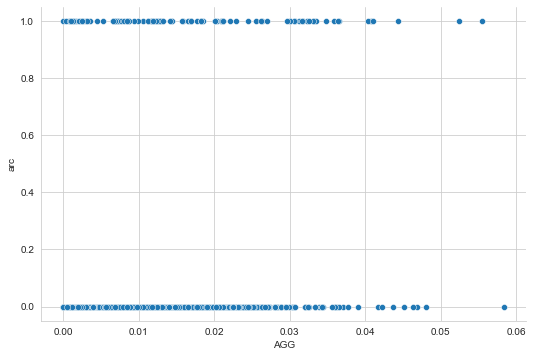

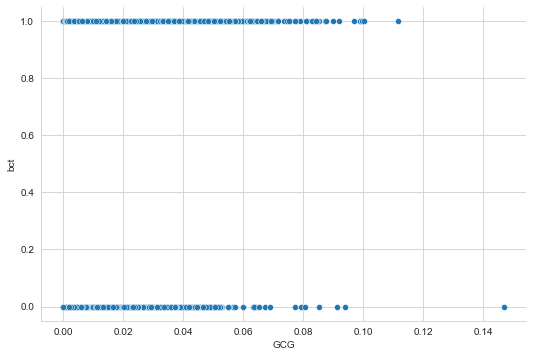

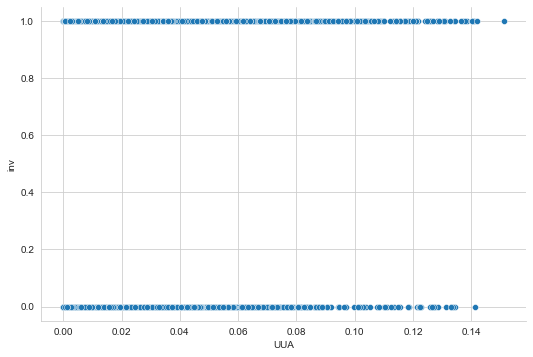

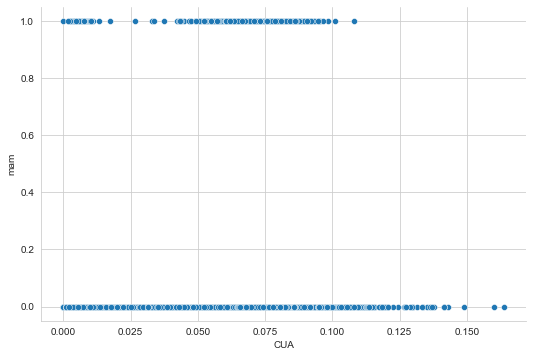

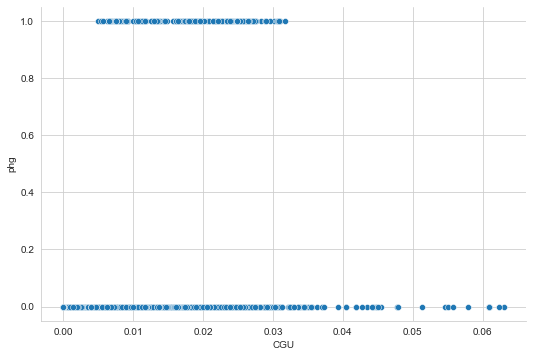

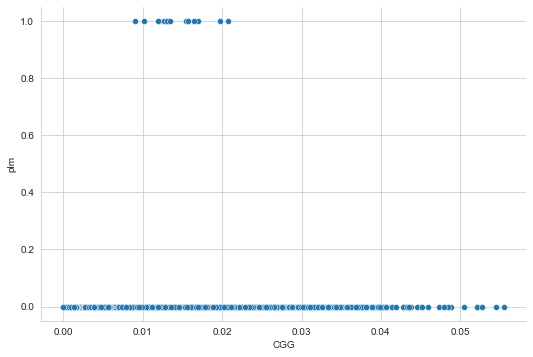

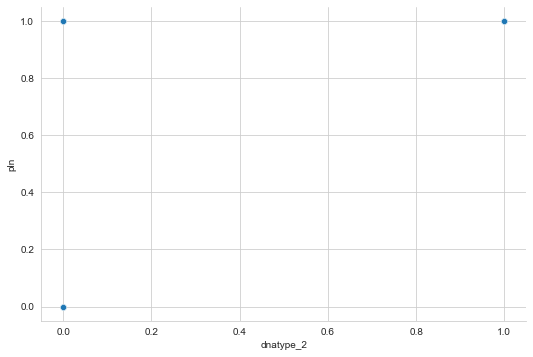

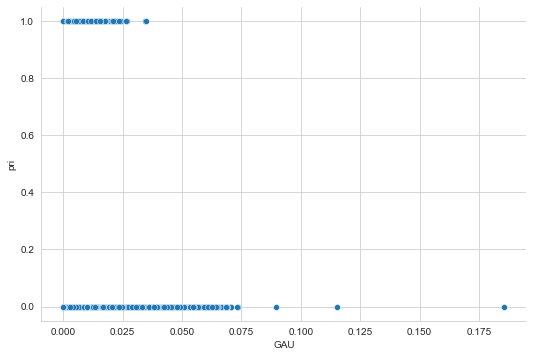

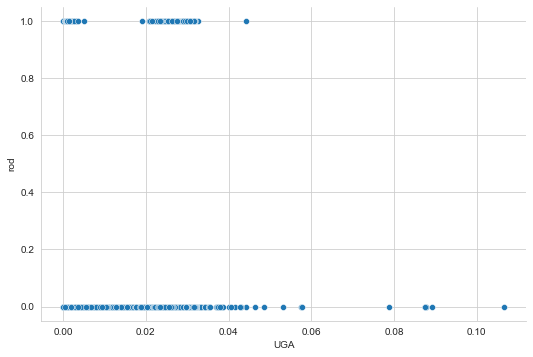

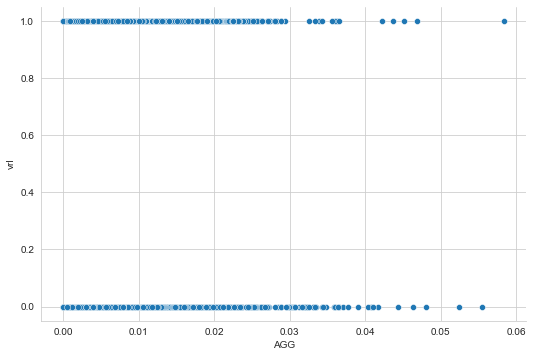

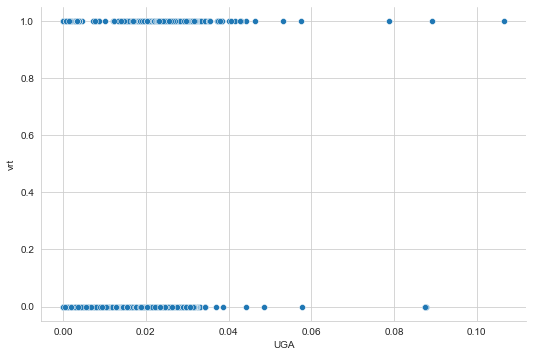

In [904]:
for item in dummies_kgd.columns:
    cor_target = abs(corrmatrix[item]).drop(item)   
    relevant_feature = cor_target[cor_target == cor_target.max()]
    print('Most correlated with',item,':',relevant_feature.index)
    _=sns.pairplot(train_corr, x_vars=relevant_feature.index,
                 y_vars=item, size=5, aspect=1.5) 


In a preliminary step, can be important also analyze the variance of our features in order to understand if our data needs normalization. 
From the plot below, we can see that the features have a variance comprised in a not so wide range, anyway we can performe a normalization using the formula:  z = (x - u) / s, that can be performed using the StandardScaler() function in the scikit-learn API. 
By this, we standardize features by removing the mean and scaling to unit variance getting the standard score.
 
The normalization will speed up our machine learning algorithm and makes our predictions more accurate giving to the features the same weight.

Moreover, standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [628]:
def visual_variance(data):
    print("Max Variance value :\t", data.var().max())
    print("Min Variance value :\t", data.var().min())
    print("Mean Variance value:\t", data.var().mean())
    plt.subplots(figsize=(20, 4))
    plot = sns.lineplot(x=data.var().index, y=data.var().values)
    plot.set_xticklabels(data, rotation=90)

Max Variance value :	 0.0005925847735596722
Min Variance value :	 8.419876539363635e-07
Mean Variance value:	 0.0001370188654865686


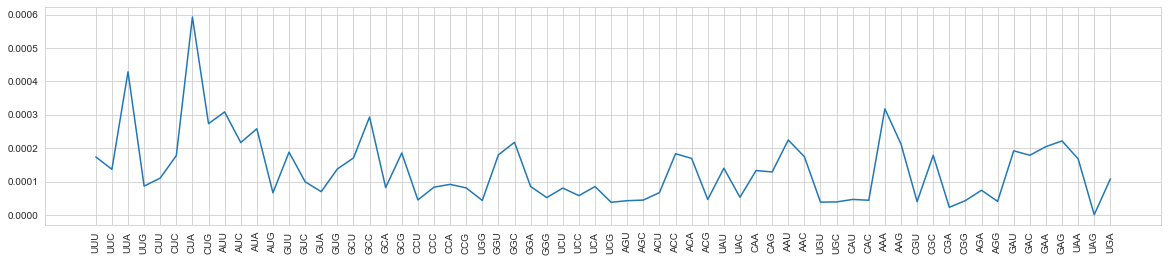

In [648]:
visual_variance(train.iloc[:,5:69])

In [649]:
train.head()

Kingdom  DNAtype  SpeciesID  Ncodons                           SpeciesName  \
0     vrl        0     207343     6686                    Bovine foamy virus   
1     inv        0       7629    10060              Anthocidaris crassispina   
2     bct        0     320850    14031               Staphylococcus phage X2   
3     bct        0       1397    39839                    Bacillus circulans   
4     vrt        1      50790     5112  mitochondrion Dascyllus trimaculatus   

       UUU      UUC      UUA      UUG      CUU  ...      AGA      AGG  \
0  0.01541  0.00927  0.01720  0.01825  0.01436  ...  0.02064  0.01182   
1  0.01213  0.02515  0.00268  0.01352  0.01372  ...  0.00915  0.01412   
2  0.02580  0.01618  0.03606  0.01354  0.00848  ...  0.01775  0.00499   
3  0.00128  0.02141  0.01225  0.01649  0.01330  ...  0.00705  0.00422   
4  0.03169  0.01780  0.03893  0.00000  0.06240  ...  0.00000  0.00000   

       GAU      GAC      GAA      GAG      UAA      UAG      UGA  \
0  0.02812  0.00838  0.03365  0.01974  0.01511  0.00030  0.00030   
1  0.03280  0.02555  0.03708  0.05398  0.03330  0.00030  0.00050   
2  0.03756  0.02523  0.05388  0.01946  0.02245  0.00121  0.00086   
3  0.03316  0.02229  0.03444  0.02370  0.00831  0.00028  0.00063   
4  0.00020  0.01389  0.02465  0.00352  0.00352  0.00000  0.02465   

   Kingdom_coded  
0              9  
1              2  
2              1  
3              1  
4             10  

[5 rows x 70 columns]

In [651]:
standard_scaler = preprocessing.StandardScaler().fit(train.iloc[:,5:69])
scaled_train = pd.DataFrame(standard_scaler.transform(train.iloc[:,5:69]), columns = train.iloc[:,5:69].columns)
scaled_train

UUU       UUC       UUA       UUG       CUU       CUC       CUA  \
0     -0.121531 -1.218064 -0.162503  0.443018 -0.327352  0.435503 -0.145888   
1     -0.370378  0.140940 -0.864018 -0.066261 -0.388269 -0.434776 -0.466323   
2      0.666739 -0.626709  0.748694 -0.064108 -0.887028  0.258446 -0.357046   
3     -1.193548 -0.179128 -0.401656  0.253519 -0.428246 -0.310986 -0.620789   
4      1.113603 -0.488070  0.887354 -1.521959  4.245238 -0.500047  1.377001   
...         ...       ...       ...       ...       ...       ...       ...   
10417  0.445963  0.520913 -0.696852  1.363596 -0.312123  0.341723 -0.555470   
10418  0.630323 -0.678913 -0.569304 -0.246070 -0.590057  0.698838 -0.382517   
10419 -0.066147  0.229087 -0.930208 -0.442029  0.838639 -0.048402 -0.695147   
10420 -1.141957 -0.504330  1.181101  1.849188  0.727275 -0.558565 -0.061260   
10421  0.040068  1.158481 -0.240288  0.472089  0.160937  2.656215  0.256299   

            CUG       AUU       AUC  ...       CGG       AGA       AGG  \
0      0.150783 -0.538745 -0.873094  ...  0.150036  1.244122  0.847396   
1      0.694014 -0.842293  0.583307  ... -0.421979 -0.092311  1.208367   
2     -0.947778  0.238634 -0.504918  ... -0.656886  0.907978 -0.224532   
3      0.598434 -0.183942  0.067725  ...  0.964585 -0.336568 -0.345379   
4     -0.264202  0.593438  0.924991  ... -0.830779 -1.156572 -1.007682   
...         ...       ...       ...  ...       ...       ...       ...   
10417 -0.373091 -0.244879 -0.378570  ...  0.020379 -0.117900  0.833271   
10418  0.283263 -0.602530 -0.362946  ... -0.103176  0.325252  0.574314   
10419  1.734501 -0.518813  0.368651  ...  1.765406 -0.953025 -0.117810   
10420 -0.642287  0.839465 -1.307162  ... -0.234358  0.664885 -0.394031   
10421 -0.526139  0.940838 -0.646890  ... -0.235883  0.883553  0.522522   

            GAU       GAC       GAA       GAG       UAA       UAG       UGA  
0      0.280650 -0.657044  0.376389 -0.130376 -0.130589 -0.315636 -0.566862  
1      0.618442  0.627596  0.616242  2.169869  1.273821 -0.315636 -0.547596  
2      0.962009  0.603654  1.791030 -0.149186  0.436116  0.676130 -0.512917  
3      0.644426  0.383687  0.431632  0.135657 -0.655602 -0.337433 -0.535073  
4     -1.734555 -0.244792 -0.252962 -1.220036 -1.025428 -0.642592  1.778793  
...         ...       ...       ...       ...       ...       ...       ...  
10417  0.467591  0.177935 -0.727073  0.456778  1.117089  0.578044 -0.595761  
10418 -0.254909 -0.740841 -0.306806  0.043620  0.103351 -0.370129 -0.559156  
10419  0.046072 -1.284027 -0.115903  0.302264 -0.252577 -0.642592 -0.259567  
10420 -0.054255  0.180179  0.486875 -0.799489 -1.145872 -0.642592 -0.406953  
10421  0.642983 -0.992233  0.749804 -0.932505 -1.146644 -0.642592 -0.407916  

[10422 rows x 64 columns]

## PCA
To study if there are structures in the data that allow samples from different classes to be easily identified we can perform a PCA and plot the data using the 3 principal components (in a 3D space), getting an idea of the shape of our data in the feature space.

Firstly, we can visualize the principal components to have a look of the number of dimensions we need to separate our data, by calculing the principal components and the percentage of variance expressed by each components. 
In the first plot, we can see the percentage of variance expressed by each component: it is not so much considering that the First Component explains about 25% of the variance.

By looking the second plot (in which the cumulative variance is represented) we can also observe that comprising at least 35 component we get a cumulative variance expressed equal to 90% approximately.

In [907]:
def compute_pc(data, n_comp):
    pca = PCA(n_comp)
    return pca.fit_transform(data), np.round(100 * pca.explained_variance_ratio_, decimals=2), pca.singular_values_

In [637]:
def visual_variance_component(data, ylab, title, cum=False, per_var=0):
    plot_labels = ['PC' + str(s) for s in range(1, len(data) + 1)]
    plt.figure(figsize=(44, 10))
    if(cum == True):
        colormat = np.where(data > 90, "#9b59b6", "#3498db")
    else:
        colormat = np.where(per_var < 1, "#9b59b6", "#3498db")
    plt.bar(x=range(1, len(data) + 1), height=data,
            tick_label=plot_labels, color=colormat)
    #plt.hlines(y = 90, xmin = 1, xmax = len(cum_var) + 1)
    plt.ylabel(ylab, size=30)
    plt.xlabel('Principal Component', size=30)
    plt.xticks(rotation=45, size=25)
    plt.yticks(size=25)
    plt.title(title, size=40)
    plt.show()
    return plot_labels

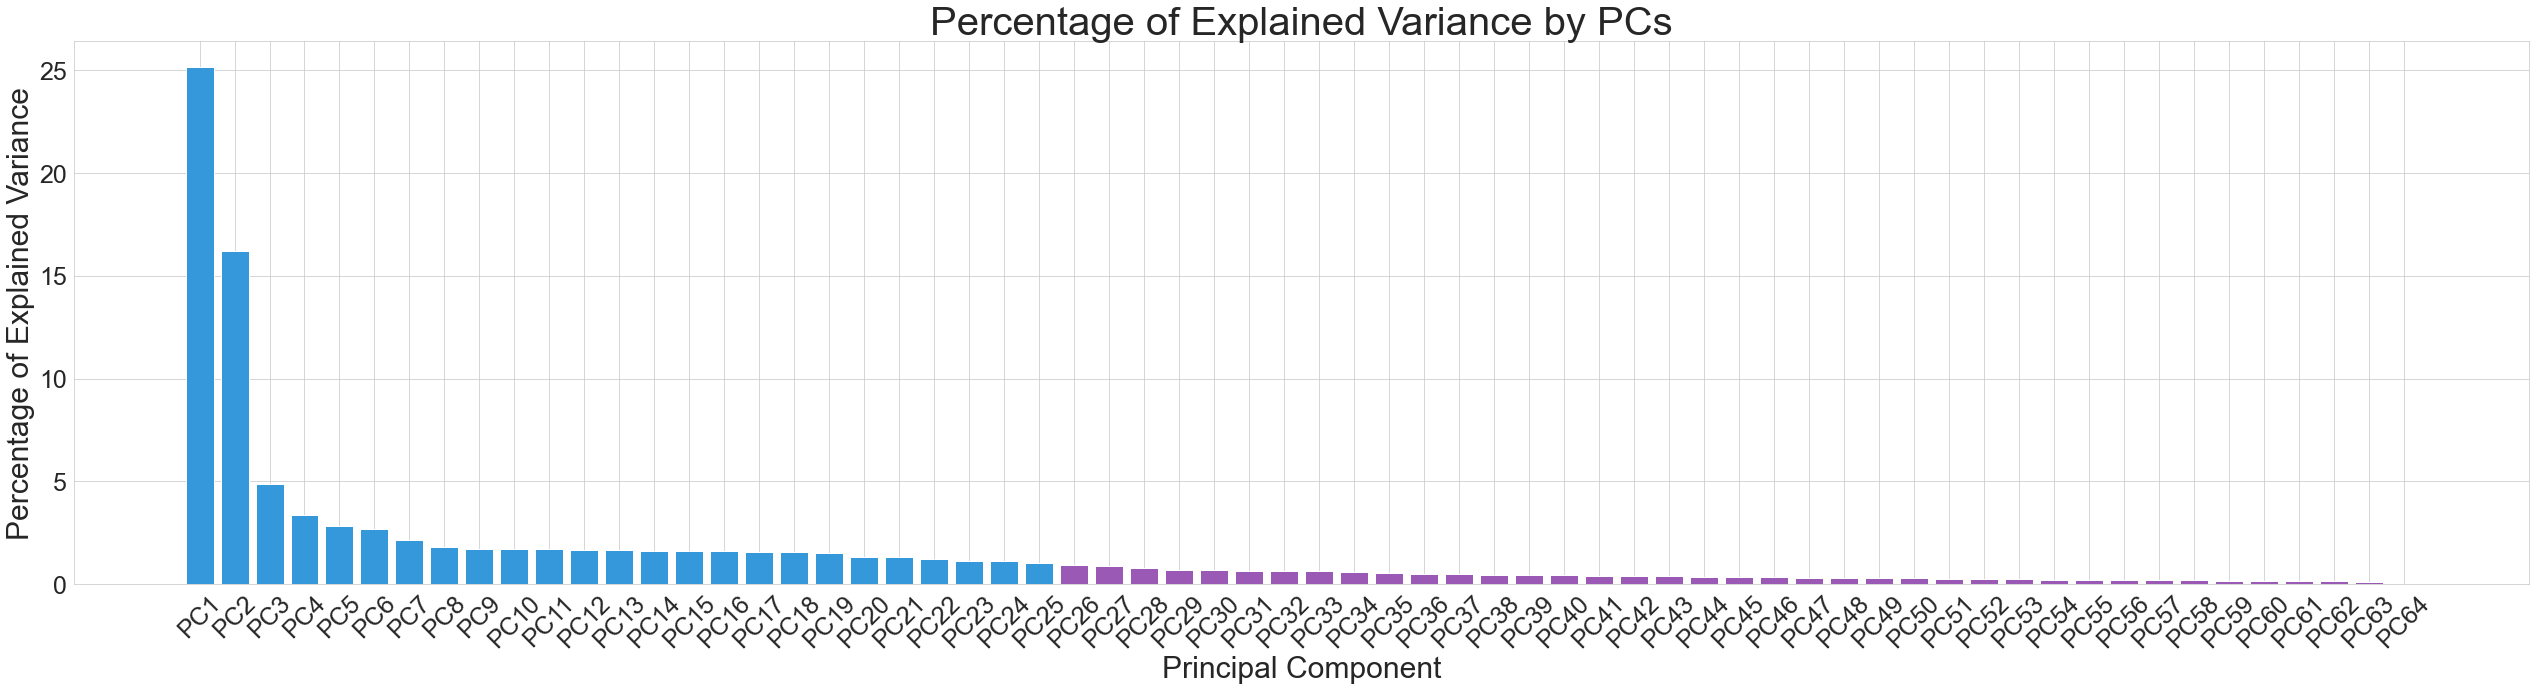

In [652]:
principalComp, per_var, singular_values = compute_pc(scaled_train, scaled_train.shape[1])
plot_labels = visual_variance_component(per_var, 'Percentage of Explained Variance', 
                                         'Percentage of Explained Variance by PCs', per_var = per_var)

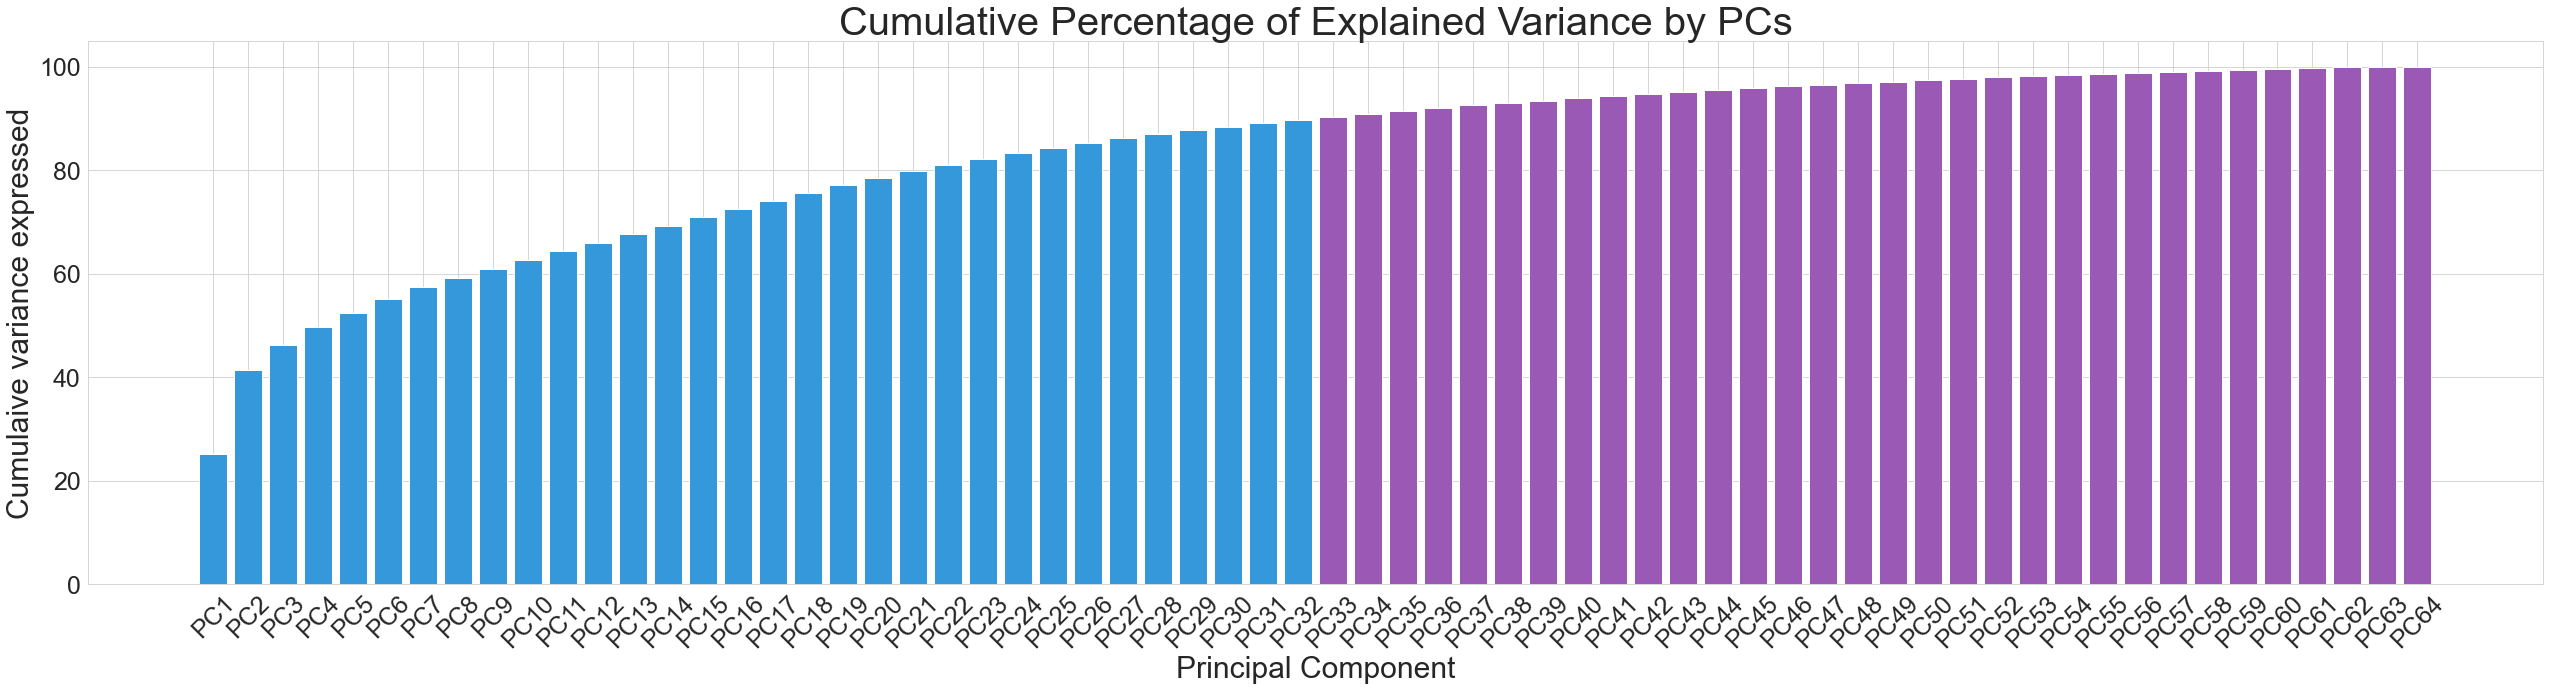

In [653]:
_ = visual_variance_component(per_var.cumsum(), 'Cumulaive variance expressed', 
                           'Cumulative Percentage of Explained Variance by PCs', cum = True)

In [654]:
pc_plot, _, _ = compute_pc(scaled_train, 3)
pc_plot = pd.DataFrame(pc_plot, columns = ['PC1','PC2','PC3'])

In [658]:
pc_plot.insert(0,'kingdom',train.Kingdom_coded)
pc_plot

kingdom       PC1       PC2       PC3
0            9 -1.540255 -1.889709  1.957284
1            2  2.404180 -1.575902  2.112928
2            1 -3.225122 -2.346969 -1.281100
3            1  2.638341 -1.736179 -1.912985
4           10 -1.834567  6.098640  0.396960
...        ...       ...       ...       ...
10417        6  1.924969 -1.162708  1.212497
10418        9  1.181863 -0.651436  1.927444
10419        1  6.183108 -0.867638 -3.164503
10420        6 -4.942004 -2.787944 -2.616916
10421        6 -3.564460 -1.987911 -0.899797

[10422 rows x 4 columns]

In [920]:
def plot3dPCA(Label, pc,clustering = False):
    unique_labelClass = np.unique(Label)
    nlabels = len(unique_labelClass)
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    cmap = plt.cm.get_cmap('Set3', nlabels)
    smap = cm.ScalarMappable(norm=mcolors.Normalize(unique_labelClass.min(),
                                                    unique_labelClass.max() + 1),   cmap=cmap)
    ax.scatter(xs=pc.PC1, ys=pc.PC2, zs=pc.PC3, marker='o', s=25,
               c=Label, cmap=cmap, edgecolors='k')
    ax.set_xlabel(pc.PC1.name, size=15)
    ax.set_ylabel(pc.PC2.name, size=15)
    ax.set_zlabel(pc.PC3.name, size=15)
    cbar = plt.colorbar(mappable=smap, label='Label Class')
    scatter = ax.scatter(pc.PC1, pc.PC2,
                     c = Label, cmap = cmap, s = 50, edgecolors='k', alpha=0.7)
    legend = ax.legend(scatter.legend_elements()[0], scatter.legend_elements()[1], loc ='upper right')
    if(clustering == False):
        legend.get_texts()[0].set_text(kgd[0])
        legend.get_texts()[1].set_text(kgd[1])
        legend.get_texts()[2].set_text(kgd[2])
        legend.get_texts()[3].set_text(kgd[3])
        legend.get_texts()[4].set_text(kgd[4])
        legend.get_texts()[5].set_text(kgd[5])
        legend.get_texts()[6].set_text(kgd[6])
        legend.get_texts()[7].set_text(kgd[7])
        legend.get_texts()[8].set_text(kgd[8])
        legend.get_texts()[9].set_text(kgd[9])
        legend.get_texts()[10].set_text(kgd[10])

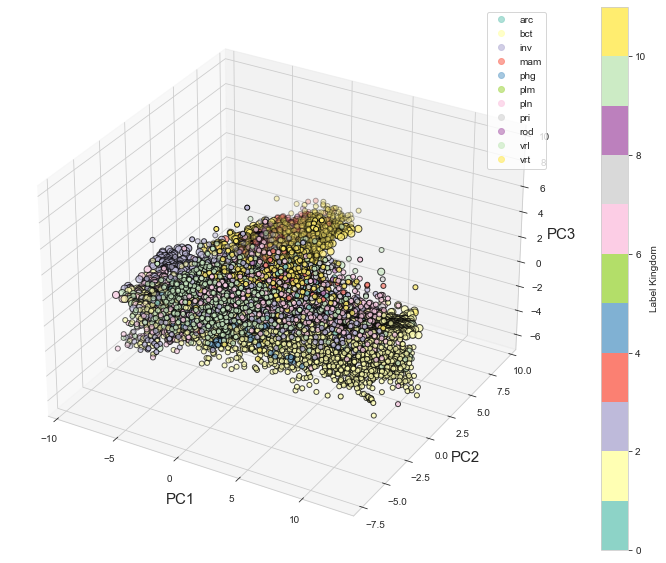

In [678]:
plot3dPCA(coded_label_kgd, pc_plot)

In [855]:
def plot2dPCA(Label, pc1, pc2,clustering = False):
    unique_labelClass = np.unique(Label)
    nlabels = len(unique_labelClass)
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111)
    cmap = plt.cm.get_cmap('Set3', nlabels)
    smap = cm.ScalarMappable(norm=mcolors.Normalize(unique_labelClass.min(),
                                                    unique_labelClass.max() + 1), cmap=cmap)
    plt.scatter(x=pc1, y=pc2, marker='o', s=25, c=Label, cmap=cmap, edgecolors='k')
    ax.set_xlabel(pc1.name, size=15)
    ax.set_ylabel(pc2.name, size=15)
    plt.colorbar(mappable=smap, label='LabelClass')
    scatter = ax.scatter(pc1, pc2,
                     c = Label, cmap = cmap, s = 50, edgecolors='k', alpha=0.7)
    legend = ax.legend(scatter.legend_elements()[0], scatter.legend_elements()[1], loc ='upper right')
    if(clustering == False):
        legend.get_texts()[0].set_text(kgd[0])
        legend.get_texts()[1].set_text(kgd[1])
        legend.get_texts()[2].set_text(kgd[2])
        legend.get_texts()[3].set_text(kgd[3])
        legend.get_texts()[4].set_text(kgd[4])
        legend.get_texts()[5].set_text(kgd[5])
        legend.get_texts()[6].set_text(kgd[6])
        legend.get_texts()[7].set_text(kgd[7])
        legend.get_texts()[8].set_text(kgd[8])
        legend.get_texts()[9].set_text(kgd[9])
        legend.get_texts()[10].set_text(kgd[10])

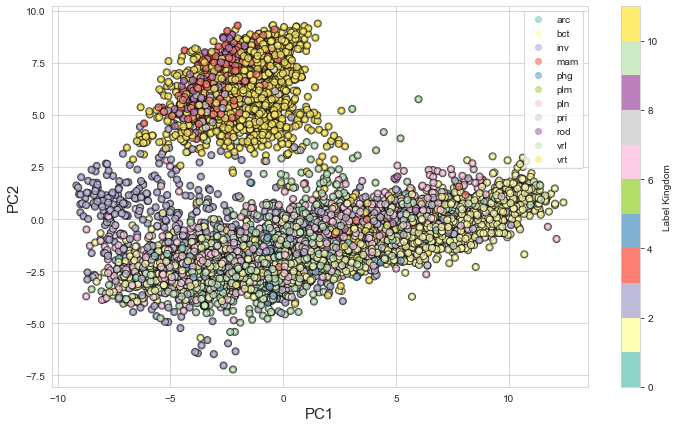

In [676]:
plot2dPCA(coded_label_kgd, pc_plot.PC1, pc_plot.PC2)

Since the dataset contains several samples, to faster the downstream analysis, we will take from each kingdom half of the samples.
From the plot of the PCA we can see how there are not so much separation between kingdom, so we could take half of the dataset.

In [792]:
#### SUBSAMPLING
newtrain0 = pd.DataFrame()

for k in dict_kingdom.values():
    d = train[train.Kingdom == k]
    if d.shape[0] > 99:
        halfd = d.sample(frac=0.50)
        newtrain0 = pd.concat([newtrain0,halfd])
    else:
        newtrain0 = pd.concat([newtrain0,d])
    
newtrain0.shape

(5217, 70)

In [681]:
new_kgd_counts=pd.DataFrame()
for name,sign in dict_kingdom.items():
    tot_train=newtrain[newtrain.Kingdom == sign].shape[0]
    
    count=pd.DataFrame()
    count['kingdom']=[sign]
    count['name']=[name]
    count['tot_train']=[tot_train]
    
    new_kgd_counts=pd.concat([new_kgd_counts,count],axis=0)
new_kgd_counts

kingdom           name  tot_train
0     arc        archaea         50
0     bct       bacteria       1168
0     inv   invertebrate        538
0     mam         mammal        229
0     phg  bacteriophage         88
0     plm        plasmid         14
0     pln          plant       1009
0     pri        primate         72
0     rod         rodent         86
0     vrl          virus       1132
0     vrt     vertebrate        831

In [793]:
# we drop some columns and store separately ACA and AGA
newtrain=newtrain0.drop(['SpeciesID','Ncodons','SpeciesName'], axis=1).reset_index()
features_AGA = newtrain.pop('AGA')
features_ACA = newtrain.pop('ACA')

In [795]:
newtrain

Kingdom  DNAtype  SpeciesID  Ncodons  \
6865     arc        0     419665   440704   
2500     arc        0     410359   608628   
2913     arc        0     384616   533466   
6341     arc        0     425386     5812   
160      arc        0     272844   542185   
...      ...      ...        ...      ...   
6414     vrt        1       7918     5498   
1016     vrt        0      27755     2106   
7822     vrt        1     373251     1783   
9239     vrt        1     181461     1784   
768      vrt        1     195827    17397   

                                     SpeciesName      UUU      UUC      UUA  \
6865             Methanococcus aeolicus Nankai-3  0.00858  0.00605  0.04585   
2500          Pyrobaculum calidifontis JCM 11548  0.01245  0.02012  0.00723   
2913             Pyrobaculum islandicum DSM 4184  0.00146  0.01423  0.01693   
6341                   Pyrococcus abyssi virus 1  0.00998  0.03097  0.00671   
160                        Pyrococcus abyssi GE5  0.00095  0.02702  0.01672   
...                                          ...      ...      ...      ...   
6414          mitochondrion Lepisosteus oculatus  0.03638  0.02546  0.03147   
1016                  Ophthalmotilapia ventralis  0.00190  0.04938  0.00522   
7822     mitochondrion Spratelloides delicatulus  0.03926  0.04262  0.01066   
9239             mitochondrion Caranx melampygus  0.02242  0.04092  0.02018   
768   mitochondrion Aphanius anatoliae anatoliae  0.02667  0.01701  0.03322   

          UUG      CUU  ...      AGA      AGG      GAU      GAC      GAA  \
6865  0.01601  0.01239  ...  0.01878  0.00682  0.04423  0.00279  0.05965   
2500  0.01929  0.01395  ...  0.01480  0.03075  0.00734  0.01104  0.01270   
2913  0.01422  0.02042  ...  0.02721  0.02104  0.01794  0.01530  0.02332   
6341  0.01669  0.03011  ...  0.01273  0.02030  0.02650  0.01824  0.02237   
160   0.01466  0.02135  ...  0.01683  0.03655  0.02752  0.03906  0.03554   
...       ...      ...  ...      ...      ...      ...      ...      ...   
6414  0.00782  0.02856  ...  0.00091  0.00036  0.00618  0.03201  0.02492   
1016  0.00950  0.01472  ...  0.00522  0.00997  0.00665  0.02802  0.01757   
7822  0.00953  0.03253  ...  0.00000  0.00000  0.00561  0.00841  0.01178   
9239  0.00673  0.03363  ...  0.00000  0.00000  0.00561  0.02859  0.02018   
768   0.00787  0.05984  ...  0.00000  0.00000  0.00339  0.00730  0.01380   

          GAG      UAA      UAG      UGA  Kingdom_coded  
6865  0.01497  0.01367  0.00032  0.00028              0  
2500  0.05711  0.03558  0.00137  0.00102              0  
2913  0.04632  0.02120  0.00126  0.00100              0  
6341  0.04456  0.00568  0.00069  0.00258              0  
160   0.05263  0.02018  0.00065  0.00169              0  
...       ...      ...      ...      ...            ...  
6414  0.00382  0.00182  0.00036  0.02692             10  
1016  0.02327  0.03799  0.00095  0.00000             10  
7822  0.01010  0.01683  0.00056  0.01683             10  
9239  0.00504  0.02522  0.00056  0.02410             10  
768   0.00851  0.03713  0.00000  0.02196             10  

[5217 rows x 70 columns]

In [700]:
X_train = newtrain.drop(['Kingdom','DNAtype','Kingdom_coded','index'], axis=1)
X_train

UUU      UUC      UUA      UUG      CUU      CUC      CUA      CUG  \
0     0.00938  0.02028  0.03487  0.01605  0.01683  0.00155  0.01906  0.01340   
1     0.01572  0.02700  0.01914  0.01996  0.01381  0.00843  0.01712  0.01360   
2     0.02446  0.03656  0.00106  0.00450  0.00736  0.00793  0.00164  0.01652   
3     0.02920  0.02669  0.00063  0.00220  0.00126  0.00126  0.00000  0.01444   
4     0.00359  0.00570  0.04425  0.00838  0.02641  0.01662  0.00778  0.00219   
...       ...      ...      ...      ...      ...      ...      ...      ...   
5212  0.01020  0.01968  0.02915  0.00729  0.03571  0.00219  0.06050  0.02114   
5213  0.01895  0.01669  0.00481  0.01612  0.01103  0.01839  0.00396  0.04017   
5214  0.02857  0.04622  0.00336  0.00000  0.02017  0.01513  0.11345  0.01092   
5215  0.07736  0.00860  0.02388  0.00860  0.06590  0.00000  0.04394  0.01242   
5216  0.01262  0.05275  0.01578  0.00045  0.01578  0.01262  0.07619  0.01398   

          AUU      AUC  ...      CGA      CGG      AGG      GAU      GAC  \
0     0.02839  0.01469  ...  0.00163  0.00102  0.01649  0.02460  0.02403   
1     0.02684  0.01645  ...  0.00160  0.00093  0.01231  0.02524  0.01991   
2     0.00883  0.03010  ...  0.01063  0.01301  0.00204  0.01276  0.04679   
3     0.00565  0.03987  ...  0.00377  0.01036  0.00031  0.00345  0.04207   
4     0.05350  0.01013  ...  0.00303  0.00192  0.00848  0.03743  0.00274   
...       ...      ...  ...      ...      ...      ...      ...      ...   
5212  0.03426  0.03571  ...  0.00802  0.00292  0.00000  0.00146  0.00364   
5213  0.02065  0.03168  ...  0.00396  0.00509  0.00792  0.02320  0.01669   
5214  0.02689  0.05378  ...  0.01261  0.00168  0.00000  0.00252  0.01176   
5215  0.03056  0.03438  ...  0.00573  0.00287  0.00000  0.00573  0.02579   
5216  0.02164  0.07124  ...  0.00902  0.00000  0.00000  0.00361  0.00316   

          GAA      GAG      UAA      UAG      UGA  
0     0.04410  0.03032  0.02039  0.00072  0.00207  
1     0.04179  0.03077  0.01288  0.00078  0.00150  
2     0.03386  0.04155  0.01276  0.00025  0.00164  
3     0.03328  0.07881  0.05369  0.00063  0.00094  
4     0.07096  0.00815  0.01461  0.00040  0.00029  
...       ...      ...      ...      ...      ...  
5212  0.00875  0.00802  0.00292  0.00073  0.02187  
5213  0.02065  0.03847  0.01782  0.00028  0.00057  
5214  0.02605  0.00504  0.00420  0.00000  0.02521  
5215  0.01433  0.00000  0.01433  0.00000  0.02674  
5216  0.01623  0.00000  0.00271  0.00000  0.02885  

[5217 rows x 62 columns]

In [701]:
standard_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = pd.DataFrame(standard_scaler.transform(X_train), columns = X_train.columns)
X_train

UUU       UUC       UUA       UUG       CUU       CUC       CUA  \
0    -0.561324 -0.287012  0.695265  0.200002 -0.092014 -1.172533 -0.004436   
1    -0.093582  0.285065 -0.067906  0.619280 -0.382705 -0.654003 -0.084250   
2     0.551224  1.098912 -0.945091 -1.038531 -1.003550 -0.691687 -0.721117   
3     0.900924  0.258674 -0.965953 -1.285166 -1.590707 -1.194389 -0.788589   
4    -0.988490 -1.528215  1.150353 -0.622470  0.830110 -0.036742 -0.468510   
...        ...       ...       ...       ...       ...       ...       ...   
5212 -0.500828 -0.338091  0.417748 -0.739353  1.725283 -1.124297  1.700458   
5213  0.144716 -0.592631 -0.763153  0.207508 -0.650294  0.096659 -0.625670   
5214  0.854445  1.921272 -0.833502 -1.521077  0.229478 -0.149040  3.878889   
5215  4.453996 -1.281336  0.162064 -0.598879  4.631226 -1.289353  1.019159   
5216 -0.322289  2.477174 -0.230922 -1.472822 -0.193082 -0.338213  2.345965   

           CUG       AUU       AUC  ...       CGA       CGG       AGG  \
0    -0.305689  0.005453 -0.703814  ... -1.119032 -0.674145  1.587272   
1    -0.293725 -0.082699 -0.585188  ... -1.125329 -0.687740  0.929645   
2    -0.119058 -1.106962  0.334838  ...  0.769927  1.137010 -0.686104   
3    -0.243479 -1.287815  0.993348  ... -0.669880  0.736713 -0.958280   
4    -0.976242  1.433506 -1.011164  ... -0.825194 -0.538195  0.327082   
...        ...       ...       ...  ...       ...       ...       ...   
5212  0.157298  0.339291  0.712959  ...  0.222129 -0.387139 -1.007051   
5213  1.295625 -0.434736  0.441332  ... -0.630002 -0.059349  0.238979   
5214 -0.454036 -0.079855  1.930899  ...  1.185498 -0.574448 -1.007051   
5215 -0.364310  0.128865  0.623315  ... -0.258507 -0.394692 -1.007051   
5216 -0.270995 -0.378433  3.107724  ...  0.432013 -0.828221 -1.007051   

           GAU       GAC       GAA       GAG       UAA       UAG       UGA  
0     0.025207  0.505220  1.111760  0.603258  0.294585  0.132351 -0.394559  
1     0.071447  0.201996  0.949382  0.633883 -0.290209  0.196674 -0.449398  
2    -0.830245  2.180309  0.391954  1.367501 -0.299553 -0.371512 -0.435929  
3    -1.502901  1.832927  0.351184  3.903182  2.887613  0.035867 -0.503274  
4     0.952187 -1.061681  2.999846 -0.905492 -0.155496 -0.210705 -0.565809  
...        ...       ...       ...       ...       ...       ...       ...  
5212 -1.646680 -0.995443 -1.373118 -0.914339 -1.065781  0.143071  1.510359  
5213 -0.075945 -0.034989 -0.536625  1.157896  0.094463 -0.339351 -0.538871  
5214 -1.570094 -0.397827 -0.157039 -1.117139 -0.966109 -0.639525  1.831694  
5215 -1.338169  0.634752 -0.980880 -1.460129 -0.177299 -0.639525  1.978892  
5216 -1.491341 -1.030770 -0.847322 -1.460129 -1.082133 -0.639525  2.181891  

[5217 rows x 62 columns]

# 1. Clustering

The focus of the clustering analysis is to understand if our data naturally aggregate in some structures. 
In this perspective, we will compare different clustering algorithms:

- **K-means** - partitioning clustering
- **DBSCAN** - density based cluster
- **Bottom up approach**  - Hierarchical Clustering


Regarding the k-means to choose the "right" number of cluster we plot the **WSS**, the **BSS** and the **Silhuette score** and then we use the **Elbow method** to select the best number of cluster.

- The **WSS** mesures the Cohesion: sum of the distances between any pair of points that are in the **same** cluster

- The **BSS** mesures the Separation: sum of the distances between any pair of points that are in **different** clusters

- The **Silhuette** combines the two above


To have an a mesurement of the "goodness" of our clustering we use the **purity** of a clustering, looking if one class belong only to one cluster.

Among the clustering performances carried out, the best one is with Kmeans.


In [866]:
def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

def sorted_sim(sim, y_pred):
    idx_sorted = np.argsort(y_pred)
    sim = sim[idx_sorted]
    sim = sim[:, idx_sorted]
    return sim


def wss(X, y_pred, metric):
    ncluster = np.unique(y_pred).shape[0]
    err = 0
    for k in range(ncluster):
        # All the points of this cluster
        X_k = X[y_pred == k]
        # Distances of all points within the cluster
        dist_mat = pairwise_distances(X_k, metric=metric)
        # Select the lower triangular part of the matrix
        triu_idx = np.tril_indices(dist_mat.shape[0], k=1)
        err += (dist_mat[triu_idx] ** 2).sum()

    return err


def bss(X, y_pred, metric):
    ncluster = np.unique(y_pred).shape[0]
    # Sort the distance matrix (as we did for the simiarity)
    dist_mat = pairwise_distances(X, metric=metric) ** 2
    dist_mat = sorted_sim(dist_mat, y_pred)
    y_sort = np.sort(y_pred)

    err = 0
    for k in range(ncluster):
        kidx = np.where(y_sort == k)[0]
        start, end = kidx[0], kidx[-1]
        err += dist_mat[start:end, end + 1:].sum()

    return err


def incidence_mat(y_pred):
    npoints = y_pred.shape[0]
    mat = np.zeros([npoints, npoints])
    # Retrieve how many different cluster ids there are
    clusters = np.unique(y_pred)
    nclusters = clusters.shape[0]

    for i in range(nclusters):
        sample_idx = np.where(y_pred == i)
        # Compute combinations of these indices
        idx = np.meshgrid(sample_idx, sample_idx)
        mat[idx[0].reshape(-1), idx[1].reshape(-1)] = 1

    return mat


def similarity_mat(X, metric):
    dist_mat = pairwise_distances(X, metric=metric)
    min_dist, max_dist = dist_mat.min(), dist_mat.max()

    sim_mat = 1 - (dist_mat - min_dist) / (max_dist - min_dist)
    return sim_mat


def correlation(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    sim = similarity_mat(X, metric)
    inc = normalize(inc.reshape(1, -1))
    sim = normalize(sim.reshape(1, -1))
    corr = (inc @ sim.T)
    return corr[0, 0]


def sorted_sim(sim, y_pred):
    idx_sorted = np.argsort(y_pred)
    # Sort the rows
    sim = sim[idx_sorted]
    # Sort the columns
    sim = sim[:, idx_sorted]

    return sim


def plot_sorted_sim(sim, y_pred):
    sim = sorted_sim(sim, y_pred)

    fig, ax = plt.subplots(figsize=(40, 30))
    ax = sns.heatmap(sim, ax=ax)
    # Remove ruler (ticks)
    ax.set_yticks([])
    ax.set_xticks([])


# to plot the Metrics

def plotMetrics(X, models, metric = 'euclidean'):
    silhouette_list, wss_list, bss_list = [], [], []
    for model in models:
        wss_list.append(wss(X, model.fit_predict(X), metric))
        bss_list.append(bss(X, model.fit_predict(X), metric))
        if model.n_clusters > 1:
            silhouette_list.append(silhouette_score(
                X, model.fit_predict(X), metric=metric))

    plt.plot(list(range(1, len(models) + 1)), wss_list, label='WSS', color='crimson')
    plt.plot(list(range(1, len(models) + 1)), wss_list, marker='o', color='crimson')
    plt.plot(list(range(1, len(models) + 1)), bss_list, label='BSS', color='forestgreen')
    plt.plot(list(range(1, len(models) + 1)), bss_list, marker='o', color='forestgreen')
    plt.legend()
    plt.show()
    plt.plot(list(range(2, len(models) + 1)), silhouette_list,
             label='Silhuette score', color='slateblue')
    plt.plot(list(range(2, len(models) + 1)),
             silhouette_list, marker='o', color='slateblue')
    plt.legend()
    plt.show()

In [867]:
def get_Ncounts(y_predict, y_true, k, j=None):
    N = y_true.shape[0]
    Nk_mask = y_predict == k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    if j is not None:
        Nj_mask = y_true == j
        Nj = Nj_mask.sum()
        Nkj = np.logical_and(Nj_mask, Nk_mask).sum()
    return N, Nk, Nj, Nkj

def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)

def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

    # to plot the dendogram
from scipy.cluster.hierarchy import dendrogram, linkage
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.affinity)

    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-6

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram
    ddata = dendrogram(Z, ax=ax, **kwargs)

    # Annotate nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:,2] == y)[0][0]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')

    return fig, ax

### K-MEANS

In k-means points are grouped together based on their neighbors, or better, on the closest centroid. Centroids are iteratively computed for each cluster. In the first step of the algorithm, centroids are initialized by K-means++ method that assigns centroids in a non-random way.

Here, the k-means finds 3 clusters and so the clusters contain different kingdoms (classes).
Since these clusters contain samples belonging to all kingdoms, even if data naturally aggregates in three clusters this is not a good clustering. Anyway, since the data belonging to the same cluster are close, the correlation is quite high.

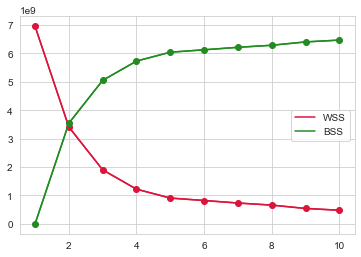

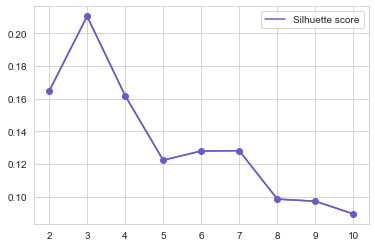

In [868]:
# KMEANS
clus_list = list(range(1, 11))    
models_KM = []
for i in clus_list:
    models_KM.append(KMeans(n_clusters = i, init = 'k-means++' , algorithm = "full", max_iter = 300, random_state = 42))
 
plotMetrics(principalComp, models_KM)

Silhouette_score:  0.2103692550353698
correlation: 0.6525094669601591
Purity:  0.42496641719302536


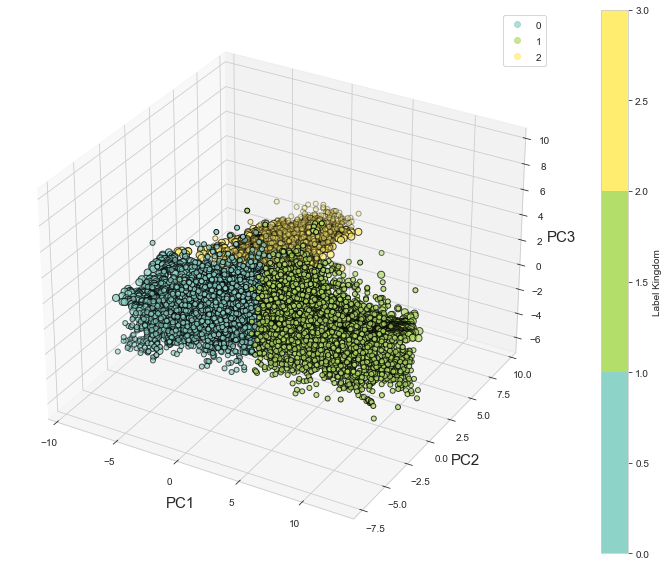

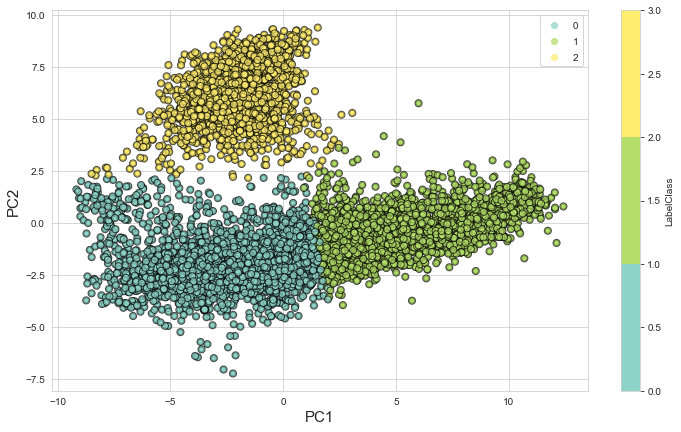

In [862]:
# according to the silhouette the best k = 3
from sklearn.preprocessing import normalize
k = 3
kmeans = KMeans(n_clusters = k, init = 'k-means++', algorithm="elkan", max_iter=100, n_init= 100)


print("Silhouette_score: ", silhouette_score(principalComp, 
                                             kmeans.fit_predict(principalComp), metric = 'euclidean'))

plot3dPCA(kmeans.fit_predict(principalComp), pc_plot, clustering = True)
plot2dPCA(kmeans.fit_predict(principalComp), pc_plot.PC1, pc_plot.PC2, clustering=True)
print('correlation:', correlation(principalComp, kmeans.fit_predict(principalComp), 'euclidean'))
print('Purity: ', tot_purity(kmeans.fit_predict(principalComp), coded_label_kgd))

### DBSCAN

DBSCAN identifies clusters based on groups with similar density. Its parameters are eps (radius) and min_samples (the number of neighbors).

The clustering using the DBSCAN algorithm give us not so good results, neither the use of KNN to first compute the min_samples or the optimization of the hyperparameters improve much.

DBSCAN(eps=4, min_samples=1)

Purity:  0.11801957396821666


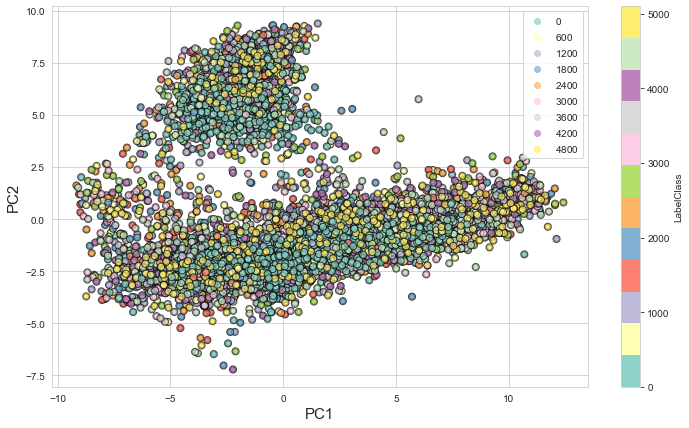

In [895]:
#DBSCAN
dbscan = DBSCAN(eps = 4, min_samples = 1)
dbscan.fit(principalComp)
y_predict_dbscan = dbscan.fit_predict(principalComp)

print('Purity: ', tot_purity(dbscan.labels_, coded_label_kgd))
plot2dPCA(y_predict_dbscan, pc_plot.PC1, pc_plot.PC2, clustering = True)

In [869]:
leaf_size = list(range(1, 100))
n_neighbors = list(range(1, 300))
p = [1, 2]
algorithm = ['ball_tree', 'kd_tree', 'brute']

hyperparameters = dict(n_neighbors = n_neighbors, p = p, algorithm = algorithm)
knn_2 = KNeighborsClassifier()

clf = GridSearchCV(estimator =  knn_2, param_grid = hyperparameters, cv = 10, n_jobs =-1)

best_model = clf.fit(principalComp,coded_label_kgd)
bestKnn =  best_model.best_estimator_
print('Best leaf_size:', bestKnn.get_params())


Best leaf_size: {'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


Purity:  0.22414123968506605


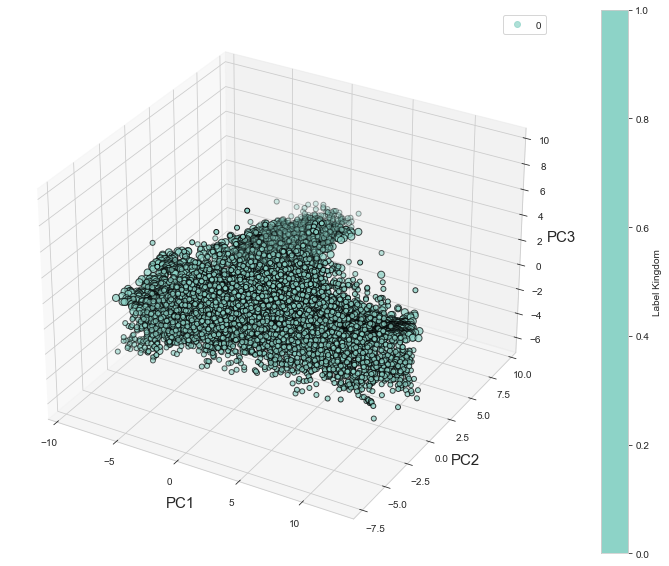

In [896]:
neigh = NearestNeighbors(n_neighbors = bestKnn.n_neighbors, leaf_size = bestKnn.leaf_size, p = bestKnn.p)
nbrs = neigh.fit(scaled_train)

distances, _ = nbrs.kneighbors(scaled_train)
distances = np.sort(distances, axis = 0)
distances = distances[:, 0]

m = DBSCAN(eps = 63 , min_samples =  bestKnn.n_neighbors).fit(principalComp)

print('Purity: ', tot_purity(m.labels_, coded_label_kgd))

plot3dPCA(m.labels_, pc_plot, clustering = True)

### HIERARCHICAL CLUSTERING
In distance-based clustering we need to choose the type of distance computed (e.g. Euclidean, cosine similarity) and how the clusters are merged (linkage: complete, single, average).
From plotting the dendograms, we can see the linkages that give us the best results are the complete (maybe for its robustness to outliers) and ward one. 
Regarding the WSS, the BSS and the Silhuette we get the same results obtained with the k-means.

Text(0.5, 1.0, 'single')

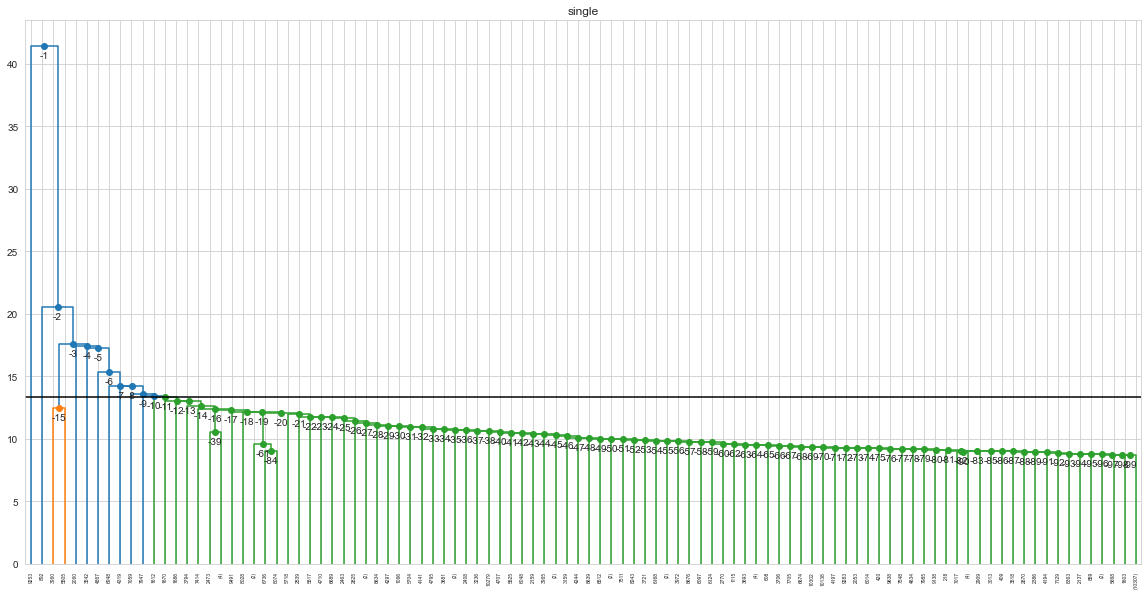

Text(0.5, 1.0, 'average')

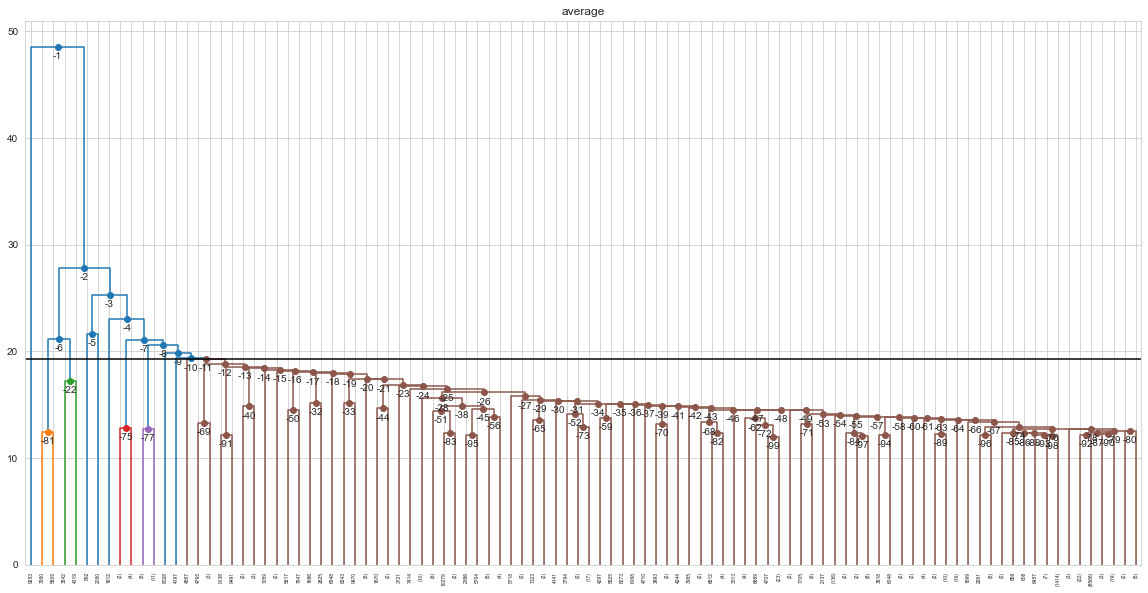

Text(0.5, 1.0, 'complete')

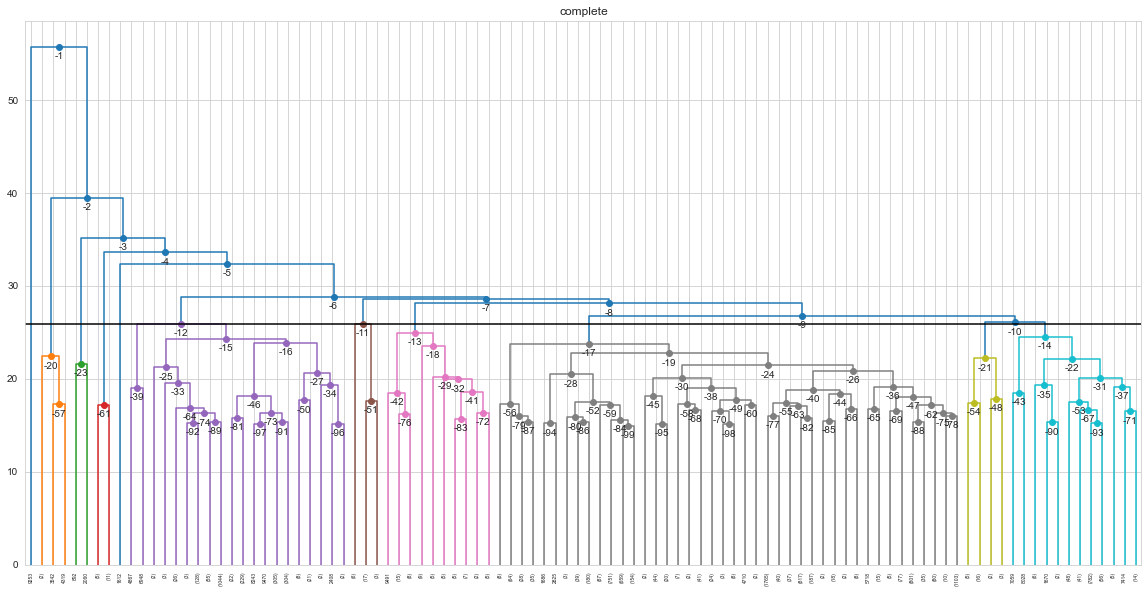

Text(0.5, 1.0, 'centroid')

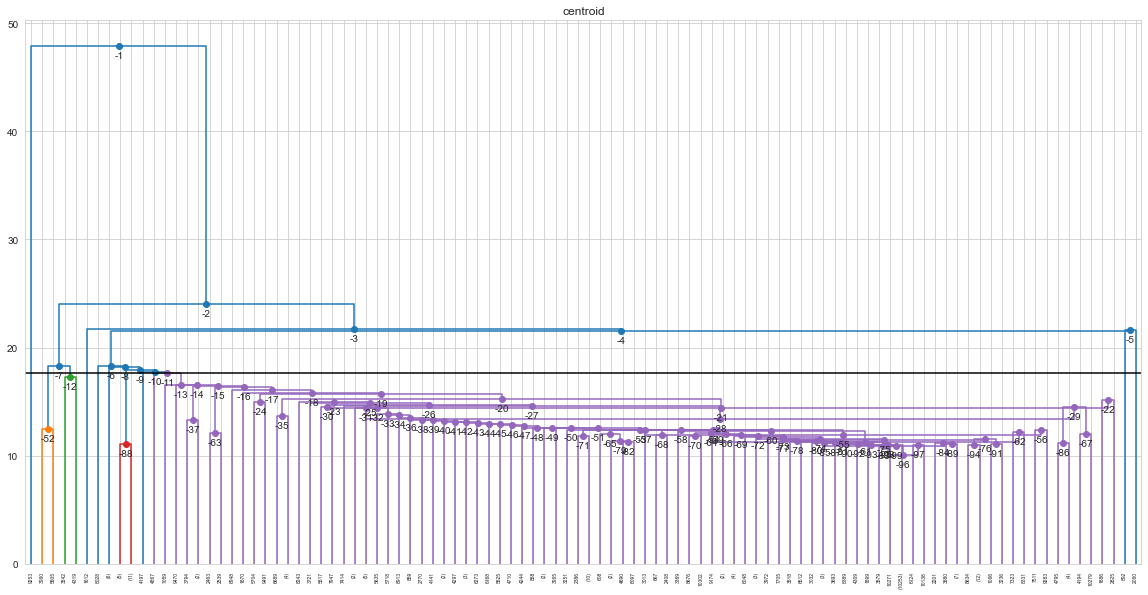

Text(0.5, 1.0, 'ward')

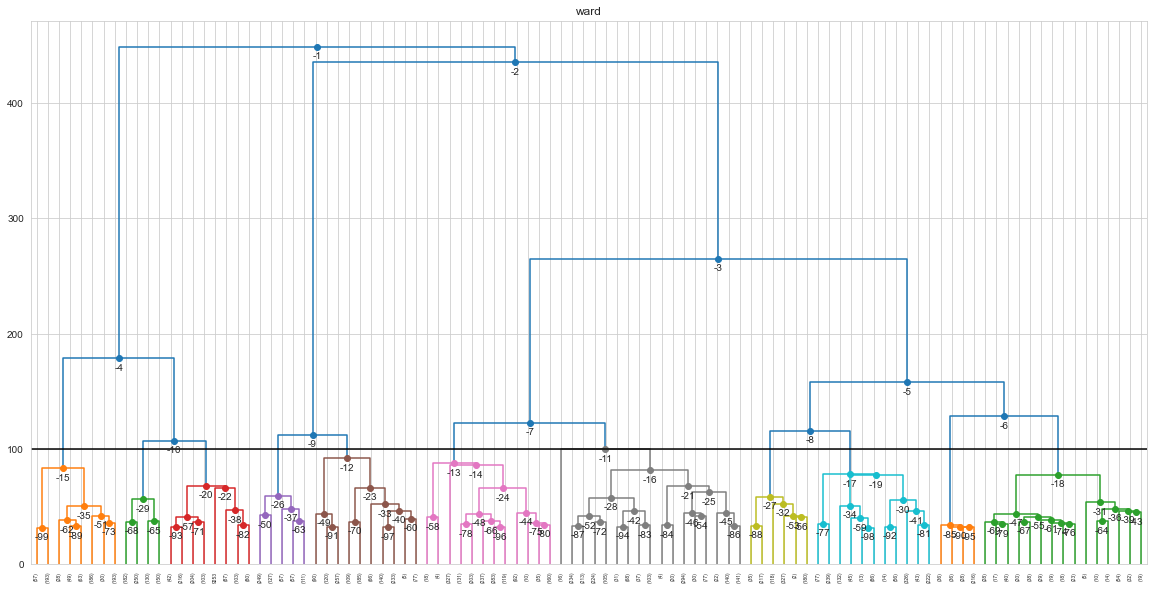

In [888]:
# Hierarchical clustering
methods = ['single', 'average', 'complete', 'centroid', 'ward']

for method in methods:
    Z = linkage(scaled_train, metric = 'euclidean', method = method)
    fig, ax = plot_dendrogram(Z = Z, X = scaled_train, truncate_mode = 'lastp', 
                              p = 100, n_clusters = 11)
    ax.set_title(method)
    plt.show()
    

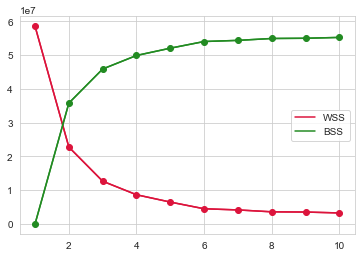

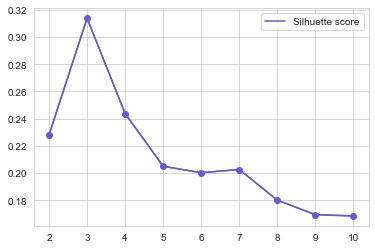

Silhouette_score:  0.11294494768649561
Correlation:  0.5246885232210493
Purity:  0.45557474572513706


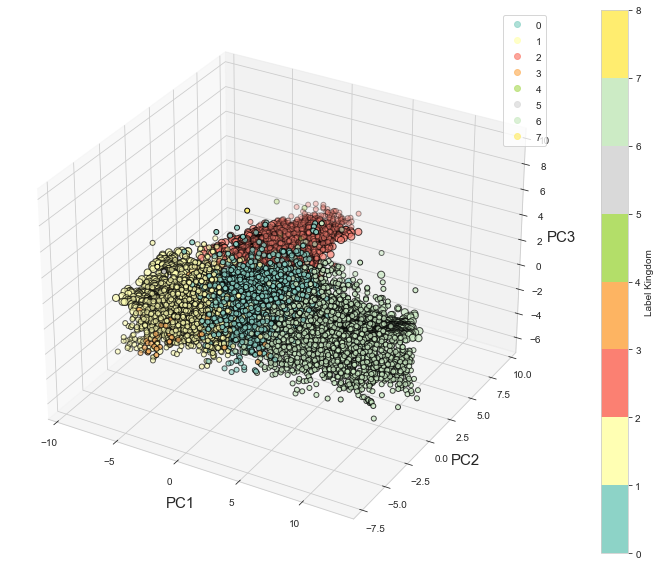

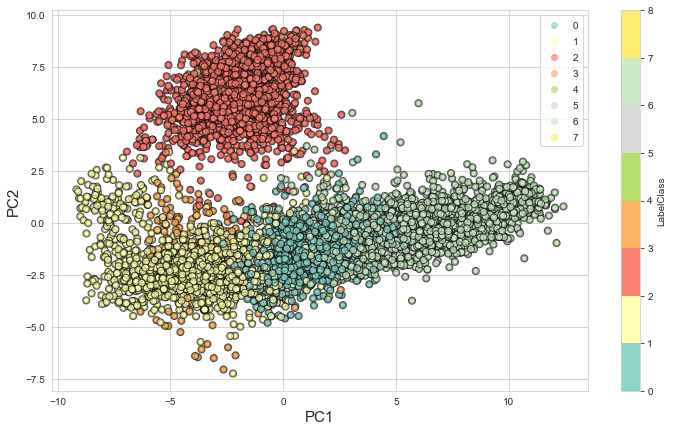

In [905]:
distance_threshold= None 
models_AG = []
similarity = ["cosine", "euclidean", "cityblock"] # affinity = j, linkage = 'complete'
for i in clus_list:
    models_AG.append(AgglomerativeClustering(n_clusters = i, 
                                             distance_threshold = distance_threshold, 
                                             affinity = "cosine", linkage = 'complete'))
    
plotMetrics(principalComp, models_AG, metric="cosine")

n_clusters = 8
agg = AgglomerativeClustering(n_clusters = n_clusters, 
                                distance_threshold = distance_threshold, 
                                affinity = "cityblock", linkage = 'complete')

y_predict_agg = agg.fit_predict(scaled_train)
plot3dPCA(y_predict_agg, pc_plot, clustering = True)
plot2dPCA(y_predict_agg, pc_plot.PC1, pc_plot.PC2, clustering = True)

print("Silhouette_score: ", silhouette_score(scaled_train, y_predict_agg, metric = 'euclidean'))
print("Correlation: ", correlation(scaled_train, y_predict_agg , "euclidean"))
print('Purity: ', tot_purity(y_predict_agg, coded_label_kgd))

## PCA: DNA type

We can also perform a PCA to investigate if there are any structures when the DNAtype is taken into account.
Remembering how different are the size of each class and that the genomic one contains the highest number of samples, plotting the PCA in 3D we can see a shape similar to the one seen distinguishing by Kingdom and the presence of three groups, that is more visualizable if we potting the First Component and the Second one. Anyway, we can clearly see how the genomic samples prevail and not are grouped in a clear pattern. 

In [908]:
pc_plot2, _, _ = compute_pc(scaled_train, 3)
pc_plot2 = pd.DataFrame(pc_plot2, columns = ['PC1','PC2','PC3'])

In [913]:
pc_plot2.insert(0,'DNAtype',train.DNAtype)
pc_plot2

DNAtype       PC1       PC2       PC3
0            0 -1.540255 -1.889709  1.958285
1            0  2.404180 -1.575903  2.112944
2            0 -3.225122 -2.346969 -1.280456
3            0  2.638341 -1.736179 -1.912702
4            1 -1.834567  6.098639  0.396675
...        ...       ...       ...       ...
10417        0  1.924969 -1.162708  1.212053
10418        0  1.181863 -0.651436  1.927276
10419        0  6.183108 -0.867638 -3.164219
10420        2 -4.942004 -2.787944 -2.618295
10421        2 -3.564460 -1.987911 -0.899358

[10422 rows x 4 columns]

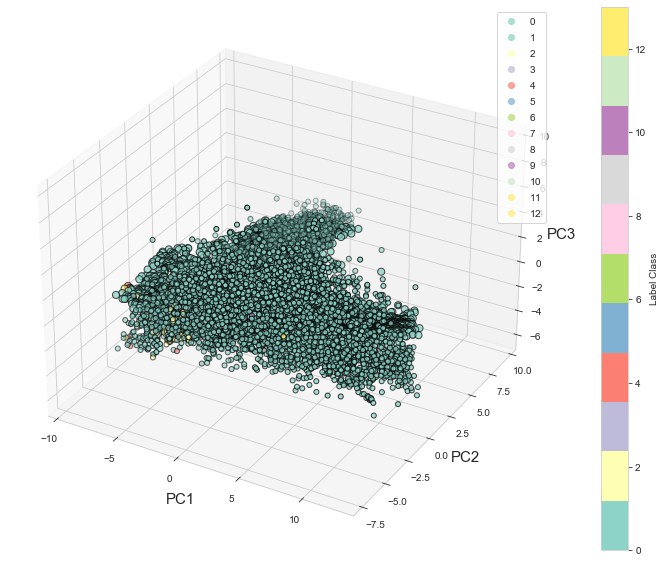

In [921]:
dtlabel = train.DNAtype
plot3dPCA(dtlabel, pc_plot2, clustering = True)

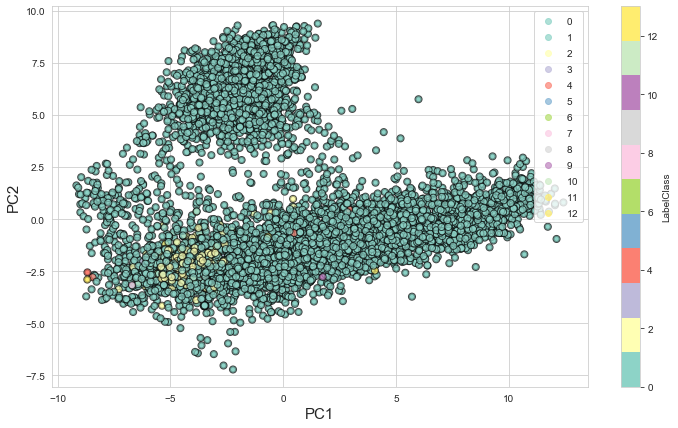

In [922]:
plot2dPCA(dtlabel, pc_plot2.PC1, pc_plot2.PC2,clustering=True)

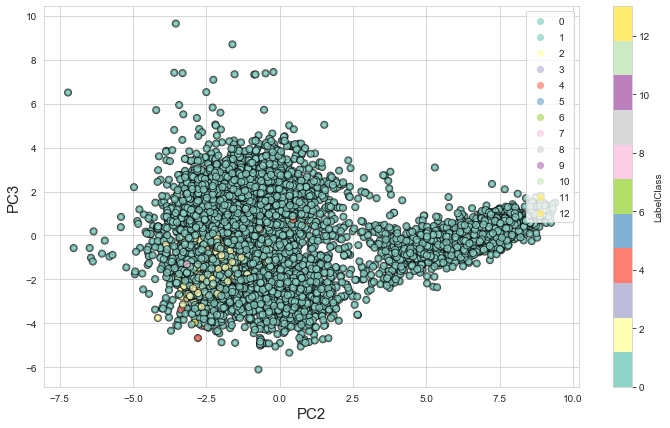

In [923]:
plot2dPCA(dtlabel, pc_plot2.PC2, pc_plot2.PC3,clustering=True)

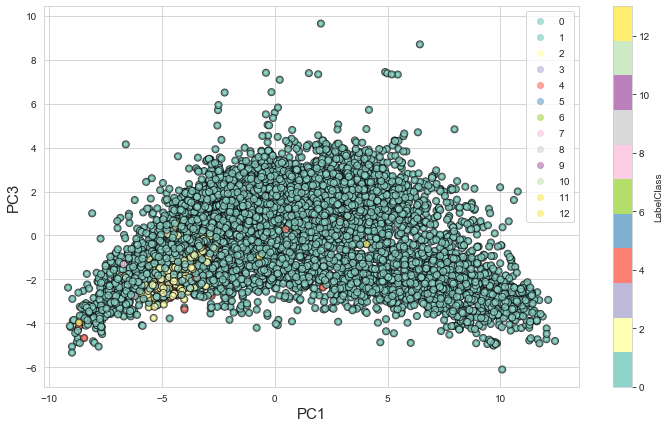

In [924]:
plot2dPCA(dtlabel, pc_plot2.PC1, pc_plot2.PC3,clustering=True)

# 2 Classification

The classification task aims to classify samples into the 11 kingdom classes.

We will carry out feature selection in order to inspect if a decreasing number of features corresponds to an increase of the accuracy.
In the test dataset the frequencies of ACA e AGA are missed, so they are not considered in this step and removed from the training set.


In [703]:
X_train.shape
X_train.head()

(5217, 62)

UUU       UUC       UUA       UUG       CUU       CUC       CUA  \
0 -0.561324 -0.287012  0.695265  0.200002 -0.092014 -1.172533 -0.004436   
1 -0.093582  0.285065 -0.067906  0.619280 -0.382705 -0.654003 -0.084250   
2  0.551224  1.098912 -0.945091 -1.038531 -1.003550 -0.691687 -0.721117   
3  0.900924  0.258674 -0.965953 -1.285166 -1.590707 -1.194389 -0.788589   
4 -0.988490 -1.528215  1.150353 -0.622470  0.830110 -0.036742 -0.468510   

        CUG       AUU       AUC  ...       CGA       CGG       AGG       GAU  \
0 -0.305689  0.005453 -0.703814  ... -1.119032 -0.674145  1.587272  0.025207   
1 -0.293725 -0.082699 -0.585188  ... -1.125329 -0.687740  0.929645  0.071447   
2 -0.119058 -1.106962  0.334838  ...  0.769927  1.137010 -0.686104 -0.830245   
3 -0.243479 -1.287815  0.993348  ... -0.669880  0.736713 -0.958280 -1.502901   
4 -0.976242  1.433506 -1.011164  ... -0.825194 -0.538195  0.327082  0.952187   

        GAC       GAA       GAG       UAA       UAG       UGA  
0  0.505220  1.111760  0.603258  0.294585  0.132351 -0.394559  
1  0.201996  0.949382  0.633883 -0.290209  0.196674 -0.449398  
2  2.180309  0.391954  1.367501 -0.299553 -0.371512 -0.435929  
3  1.832927  0.351184  3.903182  2.887613  0.035867 -0.503274  
4 -1.061681  2.999846 -0.905492 -0.155496 -0.210705 -0.565809  

[5 rows x 62 columns]

In [764]:
y_train = newtrain.reset_index().Kingdom_coded

### FEATURE SELECTION

Machine Learning algorithms do not work very well in high dimensional spaces, so it always a good practice to try a feature selection. It aims to find the most relevant features, so the features capable of giving us the information we need, in order to solve the problems we are facing. 

In this case we will perform the feature selection in order to achieve better results in the classification of our sample as well as speeds up the training time of the model. 

We will use the **Recursive Feature Elimination**, a method implemented in the scikit-learn API, similar to the Backwards Feature Selection. 
The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 
    
  1) First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute (such as coef_, feature_importances_) or callable. 

  2) Then, the least important features are pruned from current set of features. 

We will use the **RFECV** (recursive feature selection cross validation) that performs RFE in a cross-validation loop to find the optimal number of features.

In [711]:
# Create the RFE object and compute a cross-validated score
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

start = time.time()
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy',
              min_features_to_select=min_features_to_select,
              n_jobs = -1)
rfecv.fit(X_train, y_train)

print('Time needed:', time.time()-start)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=SVC(kernel='linear'), n_jobs=-1, scoring='accuracy')

Time needed: 218.42239379882812


Optimal number of features : 52


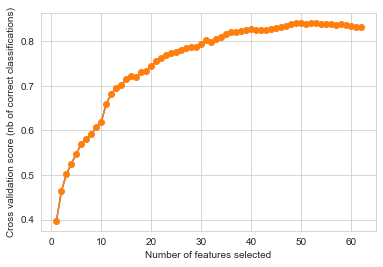

In [712]:
# Plot number of features VS. cross-validation scores
print("Optimal number of features : %d" % rfecv.n_features_)

_=plt.figure()
_=plt.xlabel("Number of features selected")
_=plt.ylabel("Cross validation score (nb of correct classifications)")
_=plt.plot(range(min_features_to_select,len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
_=plt.plot(range(min_features_to_select,len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_, marker='o')
plt.show()

We can see that the best number of features according to the cross validation on the SMV is 52, near to the number of features of the whole dataset (62), so we will use the whole set of features.

### CLASSIFICATION ALGORITHMS COMPARISON

In this section we will select our model among the following:

- KNN
- Logistic Regression
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- Support Vector Machines
- Random Forest
- Decision Tree

We will use the **k-folds cross validation** with k=10, a value that has been found to generally result in a model skill estimate with low bias a modest variance.
Cross-validation is a resampling procedure used to evaluate machine learning models.
The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. 

The general procedure is as follows:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
    For each unique group:
    - Take the group as a hold out or test data set
    - Take the remaining groups as a training data set
    - Fit a model on the training set and evaluate it on the test set using as a score the accuracy
    - Retain the evaluation score and discard the model
3. Summarize the skill of the model using the sample of model evaluation scores


This procedure is implemented in the cross_val_score function of the scikit-learn API.

Then we will try to **tune the hyperparameters** of the two models with the highest cross validation score. 
After that we will use the test set to have a look of how the model performs on new data using the test set.

Comparison evaluation: we will consider the **accuracy**, which is the fraction of correctly classified samples. 


In [714]:
classifiers = {"5 Nearest Neighbors": KNeighborsClassifier(5), 
                "Logistic Regression" : LogisticRegression(),
                "LDA":  LDA(),
                "QDA": QDA(), 
                "SVM": SVC(),
                "Random Forest": RandomForestClassifier(),
                "Decision Tree": DecisionTreeClassifier()}

In [768]:
%%capture --no-stdout --no-display

start=time.time()
comparison=pd.DataFrame()

for name, model in classifiers.items():
    cv_scores, test_scores = [], []
    score = cross_val_score(model, X_train, y_train, scoring = 'accuracy', cv = 10, n_jobs=-1)
    
    cv_score = np.mean(score)
    cv_scores.append(cv_score)
    
    s=pd.DataFrame()
    s['model'] = [name] 
    s['metric'] = ['5-cv accuracy'] * len(cv_scores) 
    s['score'] = cv_scores 
    
    comparison=pd.concat([comparison,s],axis=0)
print('Time needed:', time.time()-start)

Time needed: 22.124632358551025


In [716]:
comparison

model         metric     score
0  5 Nearest Neighbors  5-cv accuracy  0.839365
0  Logistic Regression  5-cv accuracy  0.820777
0                  LDA  5-cv accuracy  0.782816
0                  QDA  5-cv accuracy  0.792603
0                  SVM  5-cv accuracy  0.879625
0        Random Forest  5-cv accuracy  0.852593
0        Decision Tree  5-cv accuracy  0.704435

Firstly, we can notice that all models get quite good results even without a hyperparameters tuning.

The worst results is obtained by Decision Tree. 
This might be due to the fact that decision tree learners create biased trees if some classes dominate, such in this case where some classes are bigger than others, moreover they can create over-complex trees that do not generalise the data well.

Another poor result is get using LDA, this could depends on the very strong assumption on the distribution of the data and of the same variance for all the classes, that LDA makes. 

By the way, the models that get the highest scores are:

- **SVM** maybe because robust to outliers and because the boundary is decided by just few points.
- **Random Forest** because it has the power to handle large data sets with higher dimensionality.

So we will choose this two models for the hyperparameters tuning in order to try to further improve the performance of this two models.

### Hyperparameters tuning

The **hyperparameters for the SVM** are:

- **C**: tells the SVM optimization how much you want to avoid misclassifying each training example:
    (smaller C, bigger the margin)
    
- **gamma**: Kernel coefficient
    (large gamma leads to high bias and low variance models, and vice-versa)
    
- **kernel**: type of kernel to map the point in the new space
    (can be linear, polynomial, sigmoid or rbf)
    
- **degree**: degree of the polynomial kernel

The **hyperparameters for the Random Forest** include:
- the **number of decision trees** in the forest

- the **number of features considered** by each tree when splitting a node


We will use the Scikit-Learn’s RandomizedSearchCV method to define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

In [739]:
%%capture --no-stdout --no-display

#SVM
param_gridSVM = {'C': np.linspace(0.001, 100, 5),  
                 'gamma': [1, 0.1, 0.01, 0.001], 
                 'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
                 'degree': range(1, 4)} 
            
grid_searchSVM = GridSearchCV(SVC(probability = True),
                             param_grid = param_gridSVM,
                             return_train_score = True,
                             cv = 10,
                             n_jobs = -1).fit(X_train, y_train) 

bestSVM = grid_searchSVM.best_estimator_
print('The cross val scor for the SVM is: ', 
      cross_val_score(bestSVM, X_train, y_train, 
                      scoring = 'accuracy', cv = 10).mean())

The cross val scor for the SVM is:  0.9037736889712533


In [741]:
print('Best params for the selected SVM model:\n', grid_searchSVM.best_params_)

Best params for the selected SVM model:
 {'C': 25.00075, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [745]:
%%capture --no-stdout --no-display
start=time.time()

#RF
param_gridRF = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [50,100, 200, 300, 1000]
}

grid_searchRF = GridSearchCV(estimator = RandomForestClassifier(), 
                             param_grid = param_gridRF, 
                             return_train_score = True,
                             cv = 10, 
                             n_jobs = -1).fit(X_train, y_train)

bestRF = grid_searchRF.best_estimator_
print('The cross val scor for the Random Forest is: ', 
     cross_val_score(bestRF, X_train, 
                     y_train, scoring = 'accuracy', cv = 10).mean())

print("Time needed: %f " % (time.time()-start))

The cross val scor for the Random Forest is:  0.8487601208992434 
Time needed: 705.878247


In [153]:
print('Best params for the selected Random Forest model:\n', grid_searchRF.best_params_)

Best params for the selected Random Forest model:
 {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'n_estimators': 1000}


We can state that SVM model reached the highest accuracy on the test so we select it as one that works the best on this dataset.
We can also see the values for the precision, the recall and the f1-score for the test.

We can notice that the average precision in 0.86 and a recall of 0.78. 

In [814]:
test = pd.read_csv("ML2021-homework-new/test.csv")
test=test.drop('Unnamed: 0', axis=1)
test=test.drop(['SpeciesID','Ncodons','SpeciesName'],axis=1)

X_test = test.drop(['Kingdom','DNAtype'],axis=1)
X_test = pd.DataFrame(standard_scaler.transform(X_test), columns = X_test.columns)

le = preprocessing.LabelEncoder()
test['Kingdom_coded']  = le.fit_transform(test['Kingdom'])
y_test = test.Kingdom_coded

In [771]:
bestSVM.fit(X_train, y_train)
bestRF.fit(X_train, y_train)
print('SVM',grid_searchSVM.best_params_, '\nTest score: ', np.round(bestSVM.score(X_test, y_test), decimals = 4))

print('\nRandom Forest', grid_searchRF.best_params_, '\nTest score: ', np.round(bestRF.score(X_test, y_test), decimals = 4))

SVC(C=25.00075, degree=1, gamma=0.01, probability=True)

RandomForestClassifier(max_depth=90, max_features=3, n_estimators=1000)

SVM {'C': 25.00075, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'} 
Test score:  0.9106

Random Forest {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'n_estimators': 1000} 
Test score:  0.8542


In [777]:
print(classification_report(y_test, bestSVM.predict(X_test), target_names = dict_kingdom.values()))

              precision    recall  f1-score   support

         arc       0.77      0.68      0.72        25
         bct       0.94      0.96      0.95       584
         inv       0.85      0.83      0.84       269
         mam       0.78      0.80      0.79       114
         phg       0.82      0.73      0.77        44
         plm       1.00      0.50      0.67         4
         pln       0.93      0.90      0.92       505
         pri       0.76      0.61      0.68        36
         rod       0.69      0.67      0.68        43
         vrl       0.93      0.95      0.94       567
         vrt       0.93      0.96      0.95       415

    accuracy                           0.91      2606
   macro avg       0.86      0.78      0.81      2606
weighted avg       0.91      0.91      0.91      2606



In [178]:
# to check target_names are correct
test.groupby('Kingdom').count()[['DNAtype']].rename(columns={'DNAtype': 'Tot'}).T

Kingdom  arc  bct  inv  mam  phg  plm  pln  pri  rod  vrl  vrt
Tot       25  584  269  114   44    4  505   36   43  567  415

Confusion matrix TEST


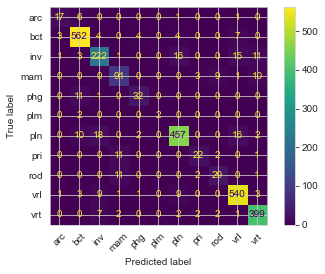

In [778]:
print('Confusion matrix TEST')
_ = plot_confusion_matrix(bestSVM, X_test, y_test, 
                      display_labels=dict_kingdom.values(), xticks_rotation='45', cmap = 'viridis')

# 3. REGRESSION

For the regression task, our focus is recover the data loss of the AGA and ACA frequencies on test samples.
We will train two different separate regressor to preict each missing feature given the remaining ones.

We will scale our data using the RobustScaler() function provided by scikit-learn API, in order to avoid that noisy data influence the regression. 
This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). 
The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Then we will use the QuantileTransformer() function to map the probability distribution of our data to a uniform or a normal distribution. This is done because for a given features, this transformation tends to spread out the most frequent values and this gave less importance to the outliers.

After that we plot the most correleted features to two targets and the residuals for both AGA ad ACA. 
We can see that even if we have done a quite strong preprocessing the residuals do not seem so "good". 
So we will then try to apply a monotonic trasformation, in particular a square root to make our data more linear.
To select the features we first detect and drop the most correleted one, then we use the SelectKBest function of the scikit-learn API using as metrics the f_regression

We plot the p-values in ascending order to see what are the features that are most correlated for AGA and for ACA. 
In order to select the best k number of features we perform a SelectKBest for each value of k. According to this procedure the number of features selected are 35 (for AGA regression) 21 (for ACA regression).
In order to create our regression model we split our dataset in traning and validation. 
We will compare:

- Linear regression
- Ridge regression
- Lasso regression
- Polynomial (2th order) with only interaction terms (synergy)
- Polynomial (2th order)

In particular it is notable to underline that we are going to use a sort of ridge polynomial regression, why this because with a tuning parameter equal to 1 is just a normal polynomial regression but changing this parameter we can get some sort of regularization and this can be useful when there are a lot of noise in particular with models that have more variance. 

Performing the k-fold cross validation and using the R2 as scoring, for both the trained regressors we obtain the best ones with the polynomial regression with only interaction term.

In [321]:
trainRG = newtrain.copy().drop(['Kingdom','DNAtype','SpeciesID','Ncodons','SpeciesName'],axis=1)

In [362]:
scaler = RobustScaler().fit(trainRG)
trainRG = pd.DataFrame(scaler.transform(trainRG), columns = trainRG.columns)

qt = QuantileTransformer(n_quantiles=100, random_state=0)
trainRG = pd.DataFrame(qt.fit_transform(trainRG), columns = trainRG.columns)

y_AGA = trainRG['AGA']
y_ACA = trainRG['ACA']

print('Inizial shape of train: ', trainRG.shape)


Inizial shape of train:  (5217, 64)


In [393]:
corrMatReg = trainRG.corr()
# Correlation with the output variable
cor_target_AGA = abs(corrMatReg['AGA']).drop('AGA')
cor_target_ACA = abs(corrMatReg['ACA']).drop('ACA')

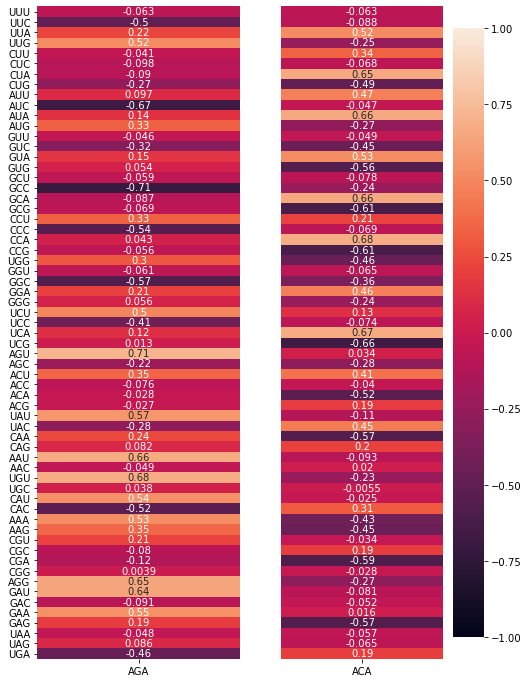

In [395]:
AGA=pd.DataFrame(corrMatReg["AGA"])
AGA.columns = ["AGA"]
AGA=AGA.drop("AGA",axis=0)

ACA=pd.DataFrame(corrMatReg["ACA"])
ACA.columns = ["ACA"]
ACA=ACA.drop("ACA",axis=0)

_=plt.figure(figsize=(8,12))
_=plt.subplot(1,2,1)
_=sns.heatmap(AGA, vmin=-1, vmax=1, annot=True,cbar=False)
_=plt.subplot(1,2,2)
_=sns.heatmap(ACA, vmin=-1, vmax=1, annot=True,yticklabels=False)

In [396]:
# Selecting the highly correlated features
relevant_features_AGA = cor_target_AGA[cor_target_AGA > 0.65]
relevant_features_ACA = cor_target_ACA[cor_target_ACA > 0.65]

max(relevant_features_AGA)
max(relevant_features_ACA)

print('The most relevant features for AGA are: ', relevant_features_AGA.shape[0],'\n')
pd.DataFrame(relevant_features_AGA).sort_values(by='AGA',ascending=False).T 
print('')
print('The most relevant features for ACA are: ', relevant_features_ACA.shape[0],'\n')
pd.DataFrame(relevant_features_ACA).sort_values(by='ACA',ascending=False).T 


0.7114298785348006

0.6780667012698292

The most relevant features for AGA are:  5 



AGU       GCC       UGU       AUC       AAU
AGA  0.71143  0.709613  0.676472  0.666757  0.664472


The most relevant features for ACA are:  6 



CCA       UCA       AUA       UCG       GCA       CUA
ACA  0.678067  0.668637  0.663221  0.660457  0.658275  0.650799

In [419]:
corrMatReg = trainRG.corr()
upper = corrMatReg.where(np.triu(np.ones(corrMatReg.shape), k = 1).astype(bool))
# Find index of feature columns with correlation greater than 0.65
to_drop_prov_AGA = [column for column in upper.columns if any(abs(upper[column]) > 0.65)]
to_drop_AGA = []

for x in to_drop_prov_AGA:
    if x not in relevant_features_AGA.index:
        to_drop_AGA.append(x)

    
print(to_drop_AGA)       
trainRG_AGA = trainRG.drop(columns = to_drop_AGA, axis = 1)
trainRG_AGA.shape

['CUG', 'AUU', 'AUA', 'GUC', 'GUA', 'GUG', 'GCG', 'CCC', 'CCG', 'GGC', 'UCU', 'UCC', 'UCA', 'UCG', 'ACA', 'ACG', 'UAU', 'CAG', 'CAU', 'CAC', 'AAA', 'AAG', 'CGG', 'AGA', 'AGG', 'GAU', 'GAA', 'GAG']


(5217, 36)

In [427]:
to_drop_prov_ACA = [column for column in upper.columns if any(abs(upper[column]) > 0.65)]
to_drop_ACA = []

for x in to_drop_prov_ACA:
    if x not in relevant_features_ACA.index:
        to_drop_ACA.append(x)

print(to_drop_ACA)
trainRG_ACA = trainRG.drop(columns = to_drop_ACA, axis = 1)
trainRG_ACA.shape


['CUG', 'AUU', 'AUC', 'GUC', 'GUA', 'GUG', 'GCC', 'GCG', 'CCC', 'CCG', 'GGC', 'UCU', 'UCC', 'AGU', 'ACA', 'ACG', 'UAU', 'CAG', 'AAU', 'UGU', 'CAU', 'CAC', 'AAA', 'AAG', 'CGG', 'AGA', 'AGG', 'GAU', 'GAA', 'GAG']


(5217, 34)

AGA


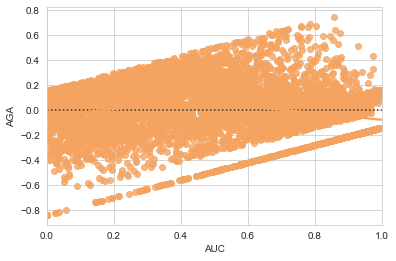

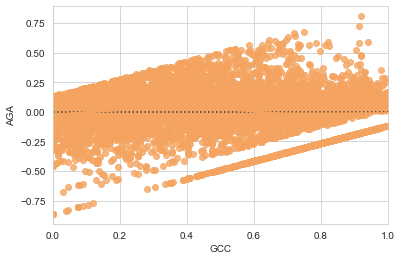

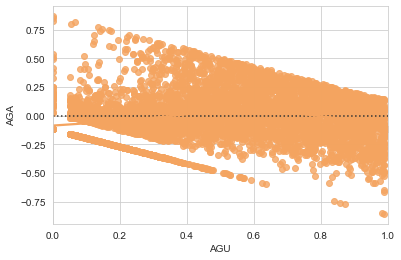

In [446]:
#Residuals AGA
print('AGA')
for column in relevant_features_AGA.index[0:3]:
    _=sns.residplot(x=trainRG_AGA[column], y=y_AGA, lowess=True, color = 'sandybrown', order=1)
    plt.show()

ACA


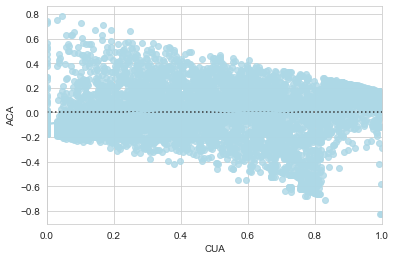

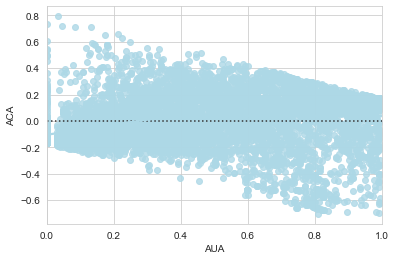

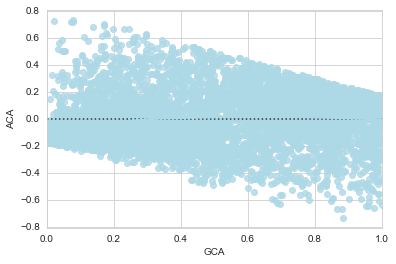

In [447]:
#Residuals ACA
print('ACA')
for column in relevant_features_ACA.index[0:3]:
    _=sns.residplot(x=trainRG_ACA[column], y=y_ACA, lowess=True, color="lightblue", order=1)
    plt.show()

In [451]:
trainRG_AGA

UUU       UUC       UUA       UUG       CUU       CUC       CUA  \
0     0.304736  0.229305  0.828735  0.393503  0.699814  0.761191  0.179355   
1     0.427095  0.820524  0.186436  0.223497  0.075840  0.990121  0.090338   
2     0.631950  0.257225  0.420723  0.917434  0.720834  0.778195  0.772244   
3     0.338115  0.792066  0.236585  0.347105  0.372303  0.957680  0.746036   
4     0.084242  0.470358  0.572479  0.784825  0.451069  0.469195  0.644837   
...        ...       ...       ...       ...       ...       ...       ...   
5212  0.145565  0.028097  0.657015  0.204987  0.990060  0.468717  0.832919   
5213  0.146740  0.229305  0.903865  0.206831  0.911476  0.973173  0.918680   
5214  0.510019  0.280551  0.974085  0.155192  0.890169  0.970565  0.828297   
5215  0.972474  0.769281  0.578550  0.090165  0.435359  0.903622  0.995008   
5216  0.730480  0.535988  0.899909  0.444748  0.967691  0.636850  0.883141   

           AUC       AUG       GUU  ...       AAC       UGU       UGC  \
0     0.430988  0.862482  0.607562  ...  0.135310  0.773745  0.556232   
1     0.886070  0.113151  0.494391  ...  0.250322  0.537996  0.180912   
2     0.244788  0.814589  0.925827  ...  0.355616  0.492417  0.272727   
3     0.249483  0.264806  0.637258  ...  0.566965  0.142251  0.479090   
4     0.517599  0.451340  0.819562  ...  0.371728  0.522840  0.380745   
...        ...       ...       ...  ...       ...       ...       ...   
5212  0.714113  0.139283  0.354175  ...  0.993063  0.000000  0.189921   
5213  0.948512  0.126298  0.743513  ...  0.000000  0.000000  0.000000   
5214  0.440008  0.080912  0.206919  ...  0.101935  0.340434  0.218210   
5215  0.985466  0.331661  0.245185  ...  0.230041  0.074829  0.266690   
5216  0.532189  0.019551  0.000000  ...  0.000000  0.268261  0.000000   

           CGU       CGC       CGA       GAC       UAA       UAG       UGA  
0     0.098178  0.030130  0.135951  0.703804  0.653417  0.387220  0.330823  
1     0.343880  0.566337  0.990605  0.270066  0.205361  0.861117  0.604383  
2     0.554433  0.647958  0.036656  0.439730  0.801974  0.915831  0.593082  
3     0.191817  0.891585  0.138696  0.222171  0.061382  0.921361  0.464646  
4     0.269381  0.756497  0.324408  0.741612  0.246693  0.747475  0.677894  
...        ...       ...       ...       ...       ...       ...       ...  
5212  0.227301  0.828412  0.000000  0.289739  0.989864  0.000000  0.847693  
5213  0.000000  0.632118  0.689985  0.139923  0.000000  0.000000  0.958224  
5214  0.183840  0.088624  0.832786  0.674041  0.409595  0.696970  0.852626  
5215  0.000000  0.140752  0.611164  0.958073  0.487655  0.000000  0.968787  
5216  0.000000  0.782720  0.832318  0.838522  0.844423  0.979798  0.962632  

[5217 rows x 36 columns]

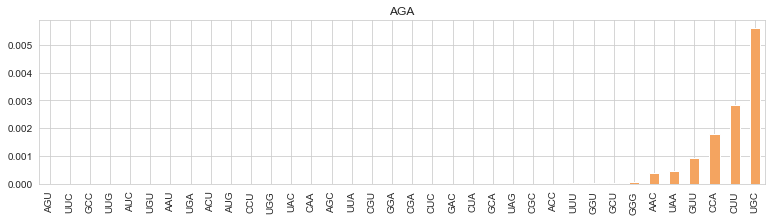

In [453]:
sel_AGA = f_regression(trainRG_AGA, y_AGA)
# first dimension F score
# second dimension p value 
p_values = pd.Series(sel_AGA[1], name = 'p_val')
p_values.index = trainRG_AGA.columns
p_values_sort = p_values.sort_values() 
_=p_values_sort.plot.bar(figsize = (13,3), title='AGA',color='sandybrown')

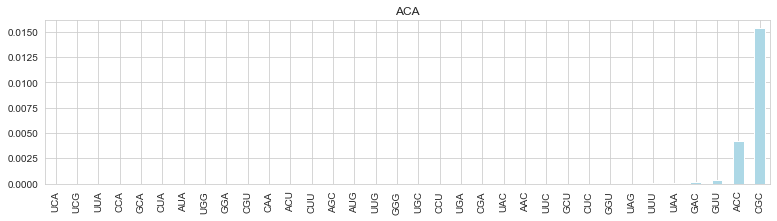

In [454]:
sel_ACA = f_regression(trainRG_ACA, y_ACA)
# first dimension F score
# second dimension p value 
p_values = pd.Series(sel_ACA[1], name = 'p_val')
p_values.index = trainRG_ACA.columns
p_values_sort = p_values.sort_values() 
_=p_values_sort.plot.bar(figsize = (13,3), title='ACA',color='lightblue')

In [459]:
trainRG_AGA = np.sqrt(trainRG_AGA)
trainRG_ACA = np.sqrt(trainRG_ACA)

In [469]:
#AGA
r2_scorer = make_scorer(r2_score, greater_is_better = True)
scoresReg_AGA = []

for k in range(1, len(trainRG_AGA.columns) + 1):
    selKBesst = SelectKBest(f_regression, k=k).fit(trainRG_AGA, y_AGA)
    X_new = selKBesst.transform(trainRG_AGA)
    X_new = pd.DataFrame(X_new, columns = trainRG_AGA.columns[selKBesst.get_support()])
    score =  cross_val_score(LinearRegression(), X_new, y_AGA, 
                             scoring = r2_scorer, cv = 10,).mean()
    scoresReg_AGA.append(score)

#ACA
r2_scorer = make_scorer(r2_score, greater_is_better = True)
scoresReg_ACA = []

for k in range(1, len(trainRG_ACA.columns) + 1):
    selKBesst = SelectKBest(f_regression, k=k).fit(trainRG_ACA, y_ACA)
    X_new = selKBesst.transform(trainRG_ACA)
    X_new = pd.DataFrame(X_new, columns = trainRG_ACA.columns[selKBesst.get_support()])
    score =  cross_val_score(LinearRegression(), X_new, y_ACA, 
                             scoring = r2_scorer, cv = 10,).mean()
    scoresReg_ACA.append(score)

In [477]:
index_AGA = scoresReg_AGA.index(max(scoresReg_AGA))
print('k =',index_AGA,': R2 score =', scoresReg_AGA[index_AGA])

k = 35 : R2 score = 0.49387280378479553


In [476]:
index_ACA = scoresReg_ACA.index(max(scoresReg_ACA))
print('k =',index_ACA,': R2 score =', scoresReg_ACA[index_ACA])

k = 21 : R2 score = 0.5391778706373658


In [480]:
selKBesst_AGA = SelectKBest(f_regression, k=index_AGA).fit(trainRG_AGA, y_AGA)
X_new_AGA = selKBesst_AGA.transform(trainRG_AGA)
X_new_AGA = pd.DataFrame(X_new_AGA, columns = trainRG_AGA.columns[selKBesst_AGA.get_support()])

selKBesst_ACA = SelectKBest(f_regression, k=index_ACA).fit(trainRG_ACA, y_ACA)
X_new_ACA = selKBesst_ACA.transform(trainRG_ACA)
X_new_ACA = pd.DataFrame(X_new_ACA, columns = trainRG_ACA.columns[selKBesst_ACA.get_support()])

trainRG_AGA.shape
X_new_AGA.shape
trainRG_ACA.shape
X_new_ACA.shape

(5217, 36)

(5217, 35)

(5217, 34)

(5217, 21)

In [482]:
start=time.time()
x_train_AGA, x_validation_AGA, y_train_AGA, y_validation_AGA = train_test_split(X_new_AGA, y_AGA, 
                                                                test_size = 0.25, random_state = 100) 
print('AGA:')
#Linear regression
scoreLin_AGA = cross_val_score(LinearRegression(), x_train_AGA,
                           y_train_AGA, scoring = r2_scorer, cv = 10)
print("Linear Regression: ", np.round(scoreLin_AGA.mean(), 4))

#Lasso
scoreLasso_AGA = cross_val_score(Lasso(alpha = 0.01), x_train_AGA,
                             y_train_AGA, scoring = r2_scorer, cv = 10)
print("Lasso: ", np.round(scoreLasso_AGA.mean(),4))

#Ridge
scoreRidge_AGA= cross_val_score(Ridge(alpha = 0.01, solver='saga'),
                            x_train_AGA, y_train_AGA, scoring = r2_scorer, cv = 10)
print("Ridge: ", np.round(scoreRidge_AGA.mean(),4))


#Polynomial interaction = True
poly_int_AGA = PolynomialFeatures(degree = 2, include_bias = True, interaction_only=True).fit(x_train_AGA)
x_train_int_AGA = poly_int_AGA.transform(x_train_AGA)
x_validation_int_AGA = poly_int_AGA.transform(x_validation_AGA)

scorePol_int_AGA = cross_val_score(Ridge(alpha = 1, solver='saga'), 
                               x_train_int_AGA, y_train_AGA, scoring = r2_scorer, cv = 10)
print("Pol_inter: ", np.round(scorePol_int_AGA.mean(),4))

#Polynomial interaction = False
poly_AGA = PolynomialFeatures(degree = 2, include_bias = True, interaction_only=False).fit(x_train_AGA)
x_train_poly_AGA = poly_AGA.transform(x_train_AGA)
x_validation_poly_AGA = poly_AGA.transform(x_validation_AGA)

scorePol_AGA = cross_val_score(Ridge(alpha = 1, solver='saga'), 
                           x_train_poly_AGA, y_train_AGA, scoring = r2_scorer, cv = 10)
print("Pol: ", np.round(scorePol_AGA.mean(), 4))
print('')
print('Time needed:', time.time()-start)

AGA:
Linear Regression:  0.6819
Lasso:  0.5519
Ridge:  0.6819
Pol_inter:  0.7516
Pol:  0.7596

Time needed: 162.80475044250488


In [483]:
start=time.time()

x_train_ACA, x_validation_ACA, y_train_ACA, y_validation_ACA = train_test_split(X_new_ACA, y_ACA, 
                                                                test_size = 0.25, random_state = 100) 
print('ACA')
#Linear Regression
scoreLin_ACA = cross_val_score(LinearRegression(), x_train_ACA,
                           y_train_ACA, scoring = r2_scorer, cv = 10)
print("Linear Regression: ", np.round(scoreLin_ACA.mean(), 4))


#Lasso
scoreLasso_ACA = cross_val_score(Lasso(alpha = 0.01), x_train_ACA,
                             y_train_ACA, scoring = r2_scorer, cv = 10)
print("Lasso: ", np.round(scoreLasso_ACA.mean(),4))

#Ridge
scoreRidge_ACA= cross_val_score(Ridge(alpha = 0.01, solver='saga'),
                            x_train_ACA, y_train_ACA, scoring = r2_scorer, cv = 10)
print("Ridge: ", np.round(scoreRidge_ACA.mean(),4))
 
#Polynomial interaction  = True
poly_int_ACA = PolynomialFeatures(degree = 2, include_bias = True, interaction_only=True).fit(x_train_ACA)
x_train_int_ACA = poly_int_ACA.transform(x_train_ACA)
x_validation_int_ACA = poly_int_ACA.transform(x_validation_ACA)

scorePol_int_ACA = cross_val_score(Ridge(alpha = 1, solver='saga'), 
                               x_train_int_ACA, y_train_ACA, scoring = r2_scorer, cv = 10)
print("Pol_inter: ", np.round(scorePol_int_ACA.mean(),4))

#Polynomial  interaction = False
poly_ACA = PolynomialFeatures(degree = 2, include_bias = True, interaction_only=False).fit(x_train_ACA)
x_train_poly_ACA = poly_ACA.transform(x_train_ACA)
x_validation_poly_ACA = poly_ACA.transform(x_validation_ACA)

scorePol_ACA = cross_val_score(Ridge(alpha = 1, solver='saga'), 
                           x_train_poly_ACA, y_train_ACA, scoring = r2_scorer, cv = 10)
print("Pol: ", np.round(scorePol_ACA.mean(), 4))
print('')
print('Time needed:', time.time()-start)

ACA
Linear Regression:  0.7199
Lasso:  0.6184
Ridge:  0.7199
Pol_inter:  0.786
Pol:  0.7922

Time needed: 36.73332190513611


In [484]:
start=time.time()
reg_AGA = LinearRegression().fit(x_train_AGA, y_train_AGA)
lasso_AGA = Lasso(alpha = 0.01).fit(x_train_AGA, y_train_AGA)
ridge_AGA = Ridge(alpha = 0.01).fit(x_train_AGA, y_train_AGA)
ply_int_AGA = Ridge(alpha = 0.01, solver='saga').fit(x_train_int_AGA, y_train_AGA)
ply_AGA = LinearRegression().fit(x_train_poly_AGA, y_train_AGA)

print('AGA:')
print("Regression: ", np.round(r2_score(y_validation_AGA, reg_AGA.predict(x_validation_AGA)),4))
print("Lasso: ", np.round(r2_score(y_validation_AGA, lasso_AGA.predict(x_validation_AGA)),4))
print("Ridge: ", np.round(r2_score(y_validation_AGA, ridge_AGA.predict(x_validation_AGA)),4))
print("Poly_inter: ", np.round(r2_score(y_validation_AGA, ply_int_AGA.predict(x_validation_int_AGA)),4))
print("Poly: ", np.round(r2_score(y_validation_AGA, ply_AGA.predict(x_validation_poly_AGA)),4))
print('')
print('Time needed:', time.time()-start)

AGA:
Regression:  0.6976
Lasso:  0.5778
Ridge:  0.6976
Poly_inter:  0.7387
Poly:  0.7211

Time needed: 15.363219499588013


In [486]:
start=time.time()
reg_ACA = LinearRegression().fit(x_train_ACA, y_train_ACA)
lasso_ACA = Lasso(alpha = 0.01).fit(x_train_ACA, y_train_ACA)
ridge_ACA = Ridge(alpha = 0.01).fit(x_train_ACA, y_train_ACA)
ply_int_ACA = Ridge(alpha = 0.01, solver='saga').fit(x_train_int_ACA, y_train_ACA)
ply_ACA = LinearRegression().fit(x_train_poly_ACA, y_train_ACA)

print('ACA:')
print("Regression: ", np.round(r2_score(y_validation_ACA, reg_ACA.predict(x_validation_ACA)),4))
print("Lasso: ", np.round(r2_score(y_validation_ACA, lasso_ACA.predict(x_validation_ACA)),4))
print("Ridge: ", np.round(r2_score(y_validation_ACA, ridge_ACA.predict(x_validation_ACA)),4))
print("Poly_inter: ", np.round(r2_score(y_validation_ACA, ply_int_ACA.predict(x_validation_int_ACA)),4))
print("Poly: ", np.round(r2_score(y_validation_ACA, ply_ACA.predict(x_validation_poly_ACA)),4))
print('')
print('Time needed:', time.time()-start)

ACA:
Regression:  0.7123
Lasso:  0.6354
Ridge:  0.7123
Poly_inter:  0.77
Poly:  0.7671

Time needed: 4.449304819107056


In [488]:
start=time.time()

parametersLasso_AGA = {'alpha' : np.linspace(0.001, 1, 1000)}
clf_inter_AGA = GridSearchCV(Ridge(), parametersLasso_AGA)
modRidge_AGA = clf_inter_AGA.fit(x_train_AGA, y_train_AGA).best_estimator_

print('AGA:')
print("Ridge: ", np.round(r2_score(y_validation_AGA, modRidge_AGA.predict(x_validation_AGA)), 4))

print('')
print('Time needed:', time.time()-start)

AGA:
Ridge:  0.6974

Time needed: 68.21788024902344


In [489]:
start=time.time()

parametersLasso_ACA = {'alpha' : np.linspace(0.001, 1, 1000)}
clf_inter_ACA = GridSearchCV(Ridge(), parametersLasso_ACA)
modRidge_ACA = clf_inter_ACA.fit(x_train_ACA, y_train_ACA).best_estimator_

print('ACA:')
print("Ridge: ", np.round(r2_score(y_validation_ACA, modRidge_ACA.predict(x_validation_ACA)), 4))
print('')
print('Time needed:', time.time()-start)

ACA:
Ridge:  0.7128

Time needed: 23.883083820343018


In [490]:
start=time.time()
parametersLasso_AGA = {'alpha' : np.linspace(0.001, 1, 1000)}
clf_inter_AGA = GridSearchCV(Ridge(), parametersLasso_AGA)
modRidgeInt_AGA = clf_inter_AGA.fit(x_train_int_AGA, y_train_AGA).best_estimator_

print('AGA:')
print("RidgeInt: ", np.round(r2_score(y_validation_AGA, modRidgeInt_AGA.predict(x_validation_int_AGA)), 4))
print('')
print('Time needed:', time.time()-start)

AGA:
RidgeInt:  0.7506

Time needed: 201.82817602157593


In [491]:
start=time.time()
parametersLasso_ACA = {'alpha' : np.linspace(0.001, 1, 1000)}
clf_inter_ACA = GridSearchCV(Ridge(), parametersLasso_ACA)
modRidgeInt_ACA = clf_inter_ACA.fit(x_train_int_ACA, y_train_ACA).best_estimator_

print('ACA:')
print("RidgeInt: ", np.round(r2_score(y_validation_ACA, modRidgeInt_ACA.predict(x_validation_int_ACA)), 4))
print('')
print('Time needed:', time.time()-start)

ACA:
RidgeInt:  0.7848

Time needed: 55.96567749977112


In [495]:
testRG = pd.read_csv("ML2021-homework-new/test.csv").drop(['Unnamed: 0','Kingdom','DNAtype',
                                                           'SpeciesName','SpeciesID','Ncodons'], axis = 1)

y_test_AGA = modRidgeInt_AGA.predict(poly_int_AGA.transform(testRG[X_new_AGA.columns]))
y_test_ACA = modRidgeInt_ACA.predict(poly_int_ACA.transform(testRG[X_new_ACA.columns]))

# 4. Recovery ACA and AGA
### Does the prediction improve?

At the end, using the regression models trained at the previous step to recover the AGA and ACA codon frequen-
cies, we will predict their value of each test sample. Then, we will determine if the test performance of the best model found at step 2. (SVC model) improves if the AGA and ACA frequency values are also used for predic-
tion.

We start adding the AGA and ACA frequencies as new columns in the test dataset. Then, we trained the selected classification model on the features plus AGA and ACA (so, usaing all 64 codons) and we test the new model on the test set, that now comprises also AGA and ACA.

In doing this, we get an accuracy for the train and also a score on the test too much high, that lead to say that some problems may occur doing again the prediction using now both AGA and ACA frequencies.

In [782]:
full_train = X_train.copy()
full_train.shape

(5217, 62)

In [783]:
features = list(full_train.columns)
features.append('AGA')
features.append('ACA')
len(features)

64

In [813]:
full_test = pd.read_csv("ML2021-homework-new/test.csv").drop(['Unnamed: 0','DNAtype',
                                                           'SpeciesName','SpeciesID','Ncodons'], axis = 1)
full_test

Kingdom      UUU      UUC      UUA      UUG      CUU      CUC      CUA  \
0        bct  0.00959  0.01359  0.01584  0.01312  0.02491  0.02457  0.01885   
1        inv  0.01223  0.03447  0.00508  0.01811  0.01176  0.02335  0.00413   
2        pln  0.01014  0.03014  0.00145  0.01275  0.01420  0.02521  0.00261   
3        pln  0.03551  0.02892  0.00155  0.01117  0.01224  0.02475  0.00511   
4        pln  0.01662  0.01400  0.02800  0.03412  0.01312  0.02625  0.02100   
...      ...      ...      ...      ...      ...      ...      ...      ...   
2601     mam  0.00694  0.02021  0.00993  0.01316  0.01435  0.01973  0.00921   
2602     bct  0.01400  0.02160  0.01327  0.02326  0.01459  0.00924  0.00480   
2603     vrt  0.00264  0.05079  0.02243  0.00132  0.03034  0.07190  0.04156   
2604     bct  0.00000  0.00502  0.05021  0.00837  0.01841  0.01757  0.00586   
2605     mam  0.03924  0.03162  0.04164  0.00263  0.02651  0.01931  0.05998   

          CUG      AUU  ...      CGA      CGG      AGG      GAU      GAC  \
0     0.01269  0.01319  ...  0.00354  0.00121  0.00709  0.02980  0.04135   
1     0.02017  0.01334  ...  0.00763  0.00524  0.01001  0.02621  0.03368   
2     0.01101  0.02492  ...  0.00551  0.00058  0.00174  0.02753  0.02695   
3     0.02233  0.01392  ...  0.00303  0.00451  0.00356  0.02865  0.02401   
4     0.01137  0.03412  ...  0.01662  0.00175  0.01837  0.03062  0.02362   
...       ...      ...  ...      ...      ...      ...      ...      ...   
2601  0.03720  0.01794  ...  0.00431  0.00502  0.01100  0.02213  0.02249   
2602  0.02757  0.02659  ...  0.00361  0.00768  0.00333  0.03314  0.02080   
2603  0.00264  0.03958  ...  0.01583  0.00264  0.00000  0.00660  0.02243   
2604  0.00167  0.03849  ...  0.00000  0.00000  0.00167  0.04770  0.05523   
2605  0.00352  0.07403  ...  0.01370  0.00209  0.00000  0.01057  0.00263   

          GAA      GAG      UAA      UAG      UGA  
0     0.02608  0.03877  0.01183  0.00061  0.00117  
1     0.02303  0.03066  0.03479  0.00064  0.00064  
2     0.00637  0.01826  0.03216  0.00116  0.00029  
3     0.01594  0.03390  0.01628  0.00108  0.00047  
4     0.03150  0.01575  0.02625  0.00087  0.00525  
...       ...      ...      ...      ...      ...  
2601  0.03744  0.03373  0.01411  0.00060  0.00167  
2602  0.04392  0.02105  0.02458  0.00040  0.00065  
2603  0.01121  0.00264  0.01451  0.00000  0.02375  
2604  0.08703  0.00418  0.00000  0.00084  0.00000  
2605  0.01285  0.00290  0.02051  0.00000  0.03142  

[2606 rows x 63 columns]

In [796]:
full_train = newtrain0[features]
standard_scaler_new = preprocessing.StandardScaler().fit(full_train)
full_train = pd.DataFrame(standard_scaler_new.transform(full_train), columns = full_train.columns)
full_train.shape

(5217, 64)

In [837]:
y_train=newtrain0.Kingdom_coded

In [824]:
full_test = pd.read_csv("ML2021-homework-new/test.csv").drop(['Unnamed: 0','Kingdom','DNAtype',
                                                           'SpeciesName','SpeciesID','Ncodons'], axis = 1)
full_test['AGA'] = y_test_AGA
full_test['ACA'] = y_test_ACA
full_test = full_test[features]
full_test = pd.DataFrame(standard_scaler_new.transform(full_test), columns = full_test.columns)
full_test.shape

(2606, 64)

In [843]:
bestSVM.fit(full_train, y_train)

SVC(C=25.00075, degree=1, gamma=0.01, probability=True)

In [844]:
print('Test score: ', np.round(bestSVM.score(full_train, y_train), decimals = 4))

Test score:  0.9981


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00      1168
           2       1.00      1.00      1.00       538
           3       0.98      1.00      0.99       229
           4       1.00      0.99      0.99        88
           5       1.00      0.86      0.92        14
           6       1.00      1.00      1.00      1009
           7       1.00      0.97      0.99        72
           8       0.99      0.97      0.98        86
           9       1.00      1.00      1.00      1132
          10       1.00      1.00      1.00       831

    accuracy                           1.00      5217
   macro avg       1.00      0.98      0.99      5217
weighted avg       1.00      1.00      1.00      5217

Confusion matrix Train


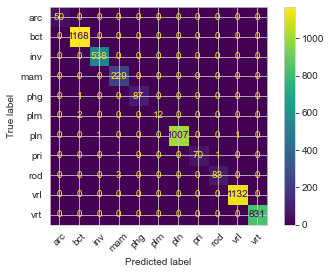

In [835]:
print(classification_report(y_train, bestSVM.predict(full_train)))
print('Confusion matrix Train')
_ = plot_confusion_matrix(bestSVM, full_train, y_train, 
                      display_labels=dict_kingdom.values(), xticks_rotation='45', cmap = 'viridis')

# 5. Conclusions

In the Preliminary analysis, we saw that some samples group together, but it is not easy to cluster the samples in 11 clusters corresponding to the Kingdom classes. K-means performed better in this regard. We identified the features most related to the 11 Kingdom classes. Then, we take into account the DNA type classes and we see that again is not easy to cluster the samples.


In the Classification task, we compared different algorithms and found out that feature selection improves not so much the performances. The best models was a SVM and a Random Forest, for the downstream analysys we select the SVM.


In the Regression task, we trained two different regressor in order to predict AGA and ACA frequencies, missed in the test dataset. We performed the k-fold cross validation and using the R2 as scoring, for both the trained regressors we obtained the best ones with the polynomial regression with only interaction term.


In the recovery part, we re-trained SVM on the training dataset including AGA and ACA and performing feature selection. This time, a limited number of features were selected for both AGA and ACA and a new classication is performed, without the desidered results, on the contrary getting results that need to be deeper investigate.
